In [1]:
#Hilfscode zum finden meines Arbeitsverzeichnis und der vorhanden Dateien
import os
print("Aktuelles Arbeitsverzeichnis:", os.getcwd())

input_dir = '/kaggle/input/'

for root, dirs, files in os.walk(input_dir):
    print(f"Verzeichnis: {root}")
    print(f"Unterordner: {dirs}")
    print(f"Dateien: {files}")
    print('---')

Aktuelles Arbeitsverzeichnis: /kaggle/working
Verzeichnis: /kaggle/input/
Unterordner: ['datasets-naivebayes']
Dateien: []
---
Verzeichnis: /kaggle/input/datasets-naivebayes
Unterordner: []
Dateien: ['dataset_base.xlsx', 'dataset.xlsx', 'dataset_roberta_sentences.xlsx', 'dataset_roberta_chunks.xlsx', 'dataset_finbert_sentences.xlsx', 'dataset_finbert_chunks.xlsx']
---


In [2]:
import pandas as pd
import numpy as np

print("Lade Datensätze...")

# Alle Datasets laden
df_data = pd.read_excel('/kaggle/input/datasets-naivebayes/dataset.xlsx')
df_base = pd.read_excel('/kaggle/input/datasets-naivebayes/dataset_base.xlsx')
df_fin_sen = pd.read_excel('/kaggle/input/datasets-naivebayes/dataset_finbert_sentences.xlsx')
df_fin_chk = pd.read_excel('/kaggle/input/datasets-naivebayes/dataset_finbert_chunks.xlsx')
df_rob_sen = pd.read_excel('/kaggle/input/datasets-naivebayes/dataset_roberta_sentences.xlsx')
df_rob_chk = pd.read_excel('/kaggle/input/datasets-naivebayes/dataset_roberta_chunks.xlsx')

# Date-Index setzen und One-Hot-Encoded columns konvertieren für alle DataFrames
for df in [df_data, df_base, df_fin_sen, df_fin_chk, df_rob_sen, df_rob_chk]:
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
    df.set_index('Date', inplace=True)
    onehot_cols = ['Index_MDAX', 'Index_SDAX']
    df[onehot_cols] = df[onehot_cols].astype(np.float64)

print("✓ Alle Datensätze erfolgreich geladen!")
print(f"df_data: {df_data.shape}")
print(f"df_base: {df_base.shape}")
print(f"df_fin_sen: {df_fin_sen.shape}")
print(f"df_fin_chk: {df_fin_chk.shape}")
print(f"df_rob_sen: {df_rob_sen.shape}")
print(f"df_rob_chk: {df_rob_chk.shape}")


Lade Datensätze...
✓ Alle Datensätze erfolgreich geladen!
df_data: (69, 14)
df_base: (69, 10)
df_fin_sen: (69, 11)
df_fin_chk: (69, 11)
df_rob_sen: (69, 11)
df_rob_chk: (69, 11)


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# Konfiguration für Train/Test-Split
config = {
    'use_fixed_testset': False,
    'test_size': 15,
    'random_state': 33,
    'fixed_test_dates': [
        '2024-01-25',
        '2023-05-04',
        '2023-02-02',
        '2025-03-06',
        '2024-10-17'
    ]
}

# Train/Test Split auf Basis von df_base
if config['use_fixed_testset']:
    # Feste Testdaten
    test_dates = pd.to_datetime(config['fixed_test_dates'])
    test_set  = df_base.loc[df_base.index.isin(test_dates)]
    train_set = df_base.loc[~df_base.index.isin(test_dates)]
else:
    # Zufällige Auswahl mit ausgewogener Interest Rate_Change
    np.random.seed(config['random_state'])
    unique_dates = df_base.index.normalize().unique()
    n_dates = config['test_size'] // 3
    
    # Datumswerte nach Kategorien sammeln
    dates_zero = []
    dates_positive = []
    dates_negative = []
    
    for date in unique_dates:
        values = df_base.loc[df_base.index.normalize() == date, 'Interest Rate_Change']
        if (values == 0.00).any():
            dates_zero.append(date)
        if (values > 0.00).any():
            dates_positive.append(date)
        if (values < 0.00).any():
            dates_negative.append(date)
    
    # Je ein Datum aus jeder Kategorie + Rest zufällig
    selected_dates = []
    selected_dates.append(np.random.choice(dates_zero))
    selected_dates.append(np.random.choice(dates_positive))
    selected_dates.append(np.random.choice(dates_negative))
    
    # Restliche Datumswerte
    remaining = [d for d in unique_dates if d not in selected_dates]
    if n_dates > 3:
        additional = np.random.choice(remaining, size=n_dates-3, replace=False)
        selected_dates.extend(additional)
    
    test_set = df_base.loc[df_base.index.normalize().isin(selected_dates)]
    train_set = df_base.loc[~df_base.index.normalize().isin(selected_dates)]

print(f"Train-Set Shape: {train_set.shape}")
print(f"Test-Set  Shape: {test_set.shape}")



############################################ numeric Metriks
import pandas as pd
from tabulate import tabulate

# --- Annahme: train_set und test_set sind bereits geladene DataFrames ---

# 1) Zusammenfassung: Instanzen & Interest Rate_Change
ir = 'Interest Rate_Change'
summary = pd.DataFrame({
    'Train': [
        len(train_set),
        f"{train_set[ir].gt(0).mean()*100:.1f}% ({train_set[ir].lt(0).mean()*100:.1f}%)"
    ],
    'Test': [
        len(test_set),
        f"{test_set[ir].gt(0).mean()*100:.1f}% ({test_set[ir].lt(0).mean()*100:.1f}%)"
    ]
}, index=['Instanzen', ir])

# 2) Kennzahlen für Zielvariablen
targets = ['Close', 'Close_t+1', 'Close_t+2']
metrics = pd.DataFrame({
    t: [
        f"{train_set[t].mean():.4f} [{test_set[t].mean():.4f}]",
        f"{train_set[t].std():.4f} [{test_set[t].std():.4f}]",
        f"{train_set[t].gt(0).mean()*100:.1f}% [{test_set[t].gt(0).mean()*100:.1f}%]",
        f"{train_set[t].le(0).mean()*100:.1f}% [{test_set[t].le(0).mean()*100:.1f}%]"
    ]
    for t in targets
}, index=['Mean', 'Std', '% Positive', '% Negative'])

# 3) Ausgabe
print(tabulate(summary.reset_index().values,
               headers=["", "Train", "Test"],
               tablefmt="github", stralign="center", numalign="center"))
print("\n" * 3, end="")
print(tabulate(metrics.reset_index().values,
               headers=["", *targets],
               tablefmt="github", stralign="center", numalign="center"))


Train-Set Shape: (54, 10)
Test-Set  Shape: (15, 10)
|                      |     Train     |     Test      |
|----------------------|---------------|---------------|
|      Instanzen       |      54       |      15       |
| Interest Rate_Change | 44.4% (22.2%) | 40.0% (40.0%) |



|            |      Close      |    Close_t+1     |    Close_t+2     |
|------------|-----------------|------------------|------------------|
|    Mean    | 0.2847 [0.6615] | 0.3467 [-0.0181] | 0.2602 [-0.4431] |
|    Std     | 1.2676 [0.9443] | 1.5951 [1.1599]  | 1.6865 [1.3372]  |
| % Positive |  59.3% [66.7%]  |  63.0% [46.7%]   |  50.0% [33.3%]   |
| % Negative |  40.7% [33.3%]  |  37.0% [53.3%]   |  50.0% [66.7%]   |


In [5]:
print("Train-Set:")
display(train_set)

print("\nTest-Set:")
display(test_set)


Train-Set:


,Close_t-4,Close_t-3,Close_t-2,Index_MDAX,Index_SDAX,Interest Rate_Old,Interest Rate_Change,Close,Close_t+1,Close_t+2
Date,,,,,,,,,,
2022-07-21,-3.141550,-2.425617,0.198991,0.0,0.0,-0.50,0.00,-0.266075,-0.213071,-0.539528
2022-07-21,-4.265666,-2.903723,-0.677581,1.0,0.0,-0.50,0.00,-0.150470,0.299553,-0.238834
2022-07-21,-4.213593,-2.455096,-0.800936,0.0,1.0,-0.50,0.00,0.188718,0.348937,-0.145770
2022-09-08,1.039798,-1.201536,-0.344767,0.0,0.0,0.00,0.50,-0.090198,1.333543,3.765106
2022-09-08,0.663098,-1.308234,-0.444066,1.0,0.0,0.00,0.50,0.519197,2.818977,4.762705
2022-09-08,1.638908,-0.569039,-0.249987,0.0,1.0,0.00,0.50,0.562792,2.367045,3.941081
2022-10-27,-3.523164,-2.003363,-1.082541,0.0,0.0,0.75,0.75,0.116855,0.360114,0.439003
2022-10-27,-5.343556,-4.006108,-1.671129,1.0,0.0,0.75,0.75,-1.118959,-2.315443,-2.204423
2022-10-27,-5.330521,-4.097239,-1.977422,0.0,1.0,0.75,0.75,0.104102,-0.893722,-1.123045



Test-Set:


,Close_t-4,Close_t-3,Close_t-2,Index_MDAX,Index_SDAX,Interest Rate_Old,Interest Rate_Change,Close,Close_t+1,Close_t+2
Date,,,,,,,,,,
2023-07-27,0.283669,0.368782,0.496731,0.0,0.0,3.50,0.25,1.702078,2.097082,1.955000
2023-07-27,-0.078090,-0.269530,0.077807,1.0,0.0,3.50,0.25,1.785418,1.524412,1.987185
2023-07-27,0.101251,0.197088,0.359499,0.0,1.0,3.50,0.25,0.500695,0.228546,0.556807
2023-09-14,0.551104,0.938800,0.392870,0.0,0.0,3.75,0.25,0.966269,1.529957,0.466909
2023-09-14,0.017334,0.549010,0.125370,1.0,0.0,3.75,0.25,0.998117,0.961341,-0.520588
2023-09-14,0.242864,0.804311,-0.106220,0.0,1.0,3.75,0.25,1.235321,0.447257,-0.613790
2024-04-11,0.429567,1.224879,-0.113884,0.0,0.0,4.00,0.00,-0.789178,-0.922679,-0.390777
2024-04-11,-0.092168,0.730216,0.194915,1.0,0.0,4.00,0.00,-0.878917,-1.347923,-1.829327
2024-04-11,-1.462324,-0.129219,-0.402328,0.0,1.0,4.00,0.00,-0.113721,-1.167655,-1.790262


# Auswahl der Regularisierung

In [64]:
#Auswahl auf Bayesian

import numpy as np
import pandas as pd
from joblib import dump
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score

# Define target and feature columns
target_columns = ['Close', 'Close_t+1', 'Close_t+2']
feature_columns = [col for col in train_set.columns if col not in target_columns]

# Prepare data arrays
X_train = train_set[feature_columns].values
X_test = test_set[feature_columns].values

# Create target dictionaries
y_train_dict = {t: train_set[t].values for t in target_columns}
y_test_dict = {t: test_set[t].values for t in target_columns}

# Calculate baseline statistics
baseline_stats = {}
for t in target_columns:
    y_tr, y_te = y_train_dict[t], y_test_dict[t]
    y_mean = np.mean(y_tr)
    
    baseline_stats[t] = {
        'train_mse': mean_squared_error(y_tr, np.full_like(y_tr, y_mean)),
        'test_mse': mean_squared_error(y_te, np.full_like(y_te, y_mean)),
        'train_r2': r2_score(y_tr, np.full_like(y_tr, y_mean)),
        'test_r2': r2_score(y_te, np.full_like(y_te, y_mean))
    }

# Scale features
scaler = StandardScaler()

# Define parameter grids for models
param_grids = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {
            'fit_intercept': [True, False]
        }
    },
    'Ridge': {
        'model': Ridge(),
        'params': {
            'alpha': np.logspace(-7, 0.05, 35),
            'max_iter': np.linspace(1, 100, 50, dtype=int),
            'fit_intercept': [True, False]
        }
    },
    'BayesianRidge': {
        'model': BayesianRidge(),
        'params': {
            'n_iter': np.linspace(1, 100, 15, dtype=int),
            'fit_intercept': [True, False]
        }
    }
}

# Define single-metric scoring
scoring = 'neg_mean_squared_error'

# Initialize results list
results = []

# Main grid search loop with MSE metric only
for target in target_columns:
    y_tr, y_te = y_train_dict[target], y_test_dict[target]
    bl = baseline_stats[target]
    
    for name, cfg in param_grids.items():
        # Configure and run grid search with MSE metric only
        grid = GridSearchCV(
            estimator=cfg['model'],
            param_grid=cfg['params'],
            scoring=scoring,
            cv=KFold(n_splits=9, shuffle=False),
            verbose=1,
            n_jobs=-1,
            return_train_score=True
        )
        
        # Perform hyperparameter optimization using scaled features
        grid.fit(scaler.fit_transform(X_train), y_tr)
        
        # Extract best results
        cv_results = grid.cv_results_
        
        # Find best index for MSE metric
        best_idx = np.argmax(cv_results['mean_test_score'])  # argmax because values are negative
        cv_score = -cv_results['mean_test_score'][best_idx]  # Convert back to positive
        
        # Get best parameters
        best_params = {}
        for param_name in cfg['params'].keys():
            best_params[param_name] = cv_results[f'param_{param_name}'][best_idx]
        
        # Create model with best parameters
        best_model = cfg['model'].__class__(**best_params)
        best_model.fit(scaler.fit_transform(X_train), y_tr)
        
        # Calculate train/test metrics
        train_pred = best_model.predict(scaler.fit_transform(X_train))
        test_pred = best_model.predict(scaler.transform(X_test))
        
        train_mse = mean_squared_error(y_tr, train_pred)
        test_mse = mean_squared_error(y_te, test_pred)
        train_r2 = r2_score(y_tr, train_pred)
        test_r2 = r2_score(y_te, test_pred)
        
        # Format metrics with baseline
        train_mse_str = f"{train_mse:.4f} ({bl['train_mse']:.4f})"
        test_mse_str = f"{test_mse:.4f} ({bl['test_mse']:.4f})"
        train_r2_str = f"{train_r2:.4f} ({bl['train_r2']:.4f})"
        test_r2_str = f"{test_r2:.4f} ({bl['test_r2']:.4f})"
        
        # Store results
        results.append({
            'Target': target,
            'Model': name,
            'CV_MSE': cv_score,
            'Train_MSE': train_mse_str,
            'Test_MSE': test_mse_str,
            'Train_R²': train_r2_str,
            'Test_R²': test_r2_str,
            'Best_Params': best_params
        })
        
        # Save the best model
        dump(best_model, f"best_model_mse_{target}_cv9.joblib")

# Create DataFrame
df_results = pd.DataFrame(results)


Fitting 9 folds for each of 2 candidates, totalling 18 fits
Fitting 9 folds for each of 3500 candidates, totalling 31500 fits
Fitting 9 folds for each of 30 candidates, totalling 270 fits
Fitting 9 folds for each of 2 candidates, totalling 18 fits
Fitting 9 folds for each of 3500 candidates, totalling 31500 fits
Fitting 9 folds for each of 30 candidates, totalling 270 fits
Fitting 9 folds for each of 2 candidates, totalling 18 fits
Fitting 9 folds for each of 3500 candidates, totalling 31500 fits
Fitting 9 folds for each of 30 candidates, totalling 270 fits


In [75]:
#Auswahl auf Bayesian, Hyperparameter auswahl, MSE

import numpy as np
import pandas as pd
from joblib import dump
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score

# Define target and feature columns
target_columns = ['Close', 'Close_t+1', 'Close_t+2']
feature_columns = [col for col in train_set.columns if col not in target_columns]

# Prepare data arrays
X_train = train_set[feature_columns].values
X_test = test_set[feature_columns].values

# Create target dictionaries
y_train_dict = {t: train_set[t].values for t in target_columns}
y_test_dict = {t: test_set[t].values for t in target_columns}

# Calculate baseline statistics
baseline_stats = {}
for t in target_columns:
    y_tr, y_te = y_train_dict[t], y_test_dict[t]
    y_mean = np.mean(y_tr)
    
    baseline_stats[t] = {
        'train_mse': mean_squared_error(y_tr, np.full_like(y_tr, y_mean)),
        'test_mse': mean_squared_error(y_te, np.full_like(y_te, y_mean)),
        'train_r2': r2_score(y_tr, np.full_like(y_tr, y_mean)),
        'test_r2': r2_score(y_te, np.full_like(y_te, y_mean))
    }

# Scale features
scaler = StandardScaler()

# Define parameter grids for models
param_grids = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {
            'fit_intercept': [True, False]
        }
    },
    'BayesianRidge': {
        'model': BayesianRidge(),
        'params': {
            'n_iter': np.linspace(1,3, 3, dtype=int),
            'tol': np.logspace(-6, -2, 3),
            #'alpha_1': np.logspace(-6, -3, 3),
            #'alpha_2': np.logspace(-6, -3, 3),
            #'lambda_1': np.logspace(-6, -3, 3),
            #'lambda_2': np.logspace(-6, -3, 3),
            'alpha_init': [None, 1.0, 0.1,],
            'lambda_init': [None, 1.0, 0.1, 0.01],
            'fit_intercept': [True, False]
        }
    }
}

# Define single-metric scoring
scoring = 'neg_mean_squared_error'

# Initialize results list
results = []

# Main grid search loop with MSE metric only
for target in target_columns:
    y_tr, y_te = y_train_dict[target], y_test_dict[target]
    bl = baseline_stats[target]
    
    for name, cfg in param_grids.items():
        # Configure and run grid search with MSE metric only
        grid = GridSearchCV(
            estimator=cfg['model'],
            param_grid=cfg['params'],
            scoring=scoring,
            cv=KFold(n_splits=9, shuffle=False),
            verbose=1,
            n_jobs=-1,
            return_train_score=True
        )
        
        # Perform hyperparameter optimization using scaled features
        grid.fit(scaler.fit_transform(X_train), y_tr)
        
        # Extract best results
        cv_results = grid.cv_results_
        
        # Find best index for MSE metric
        best_idx = np.argmax(cv_results['mean_test_score'])  # argmax because values are negative
        cv_score = -cv_results['mean_test_score'][best_idx]  # Convert back to positive
        
        # Get best parameters
        best_params = {}
        for param_name in cfg['params'].keys():
            best_params[param_name] = cv_results[f'param_{param_name}'][best_idx]
        
        # Create model with best parameters
        best_model = cfg['model'].__class__(**best_params)
        best_model.fit(scaler.fit_transform(X_train), y_tr)
        
        # Calculate train/test metrics
        train_pred = best_model.predict(scaler.fit_transform(X_train))
        test_pred = best_model.predict(scaler.transform(X_test))
        
        train_mse = mean_squared_error(y_tr, train_pred)
        test_mse = mean_squared_error(y_te, test_pred)
        train_r2 = r2_score(y_tr, train_pred)
        test_r2 = r2_score(y_te, test_pred)
        
        # Format metrics with baseline
        train_mse_str = f"{train_mse:.4f} ({bl['train_mse']:.4f})"
        test_mse_str = f"{test_mse:.4f} ({bl['test_mse']:.4f})"
        train_r2_str = f"{train_r2:.4f} ({bl['train_r2']:.4f})"
        test_r2_str = f"{test_r2:.4f} ({bl['test_r2']:.4f})"
        
        # Store results
        results.append({
            'Target': target,
            'Model': name,
            'CV_MSE': cv_score,
            'Train_MSE': train_mse_str,
            'Test_MSE': test_mse_str,
            'Train_R²': train_r2_str,
            'Test_R²': test_r2_str,
            'Best_Params': best_params
        })
        
        # Save the best model
        dump(best_model, f"best_model_mse_{target}_cv9.joblib")

# Create DataFrame
df_results = pd.DataFrame(results)


Fitting 9 folds for each of 2 candidates, totalling 18 fits
Fitting 9 folds for each of 216 candidates, totalling 1944 fits
Fitting 9 folds for each of 2 candidates, totalling 18 fits
Fitting 9 folds for each of 216 candidates, totalling 1944 fits
Fitting 9 folds for each of 2 candidates, totalling 18 fits
Fitting 9 folds for each of 216 candidates, totalling 1944 fits


In [78]:
#Auswahl der Optimierungsmetric, auswahl MSE

import numpy as np
import pandas as pd
from joblib import dump
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Define target and feature columns
target_columns = ['Close', 'Close_t+1', 'Close_t+2']
feature_columns = [col for col in train_set.columns if col not in target_columns]

# Prepare data arrays
X_train = train_set[feature_columns].values
X_test = test_set[feature_columns].values

# Create target dictionaries
y_train_dict = {t: train_set[t].values for t in target_columns}
y_test_dict = {t: test_set[t].values for t in target_columns}

# Calculate baseline statistics
baseline_stats = {}
for t in target_columns:
    y_tr, y_te = y_train_dict[t], y_test_dict[t]
    y_mean = np.mean(y_tr)
    
    baseline_stats[t] = {
        'train_mse': mean_squared_error(y_tr, np.full_like(y_tr, y_mean)),
        'test_mse': mean_squared_error(y_te, np.full_like(y_te, y_mean)),
        'train_r2': r2_score(y_tr, np.full_like(y_tr, y_mean)),
        'test_r2': r2_score(y_te, np.full_like(y_te, y_mean)),
        'train_mae': mean_absolute_error(y_tr, np.full_like(y_tr, y_mean)),
        'test_mae': mean_absolute_error(y_te, np.full_like(y_te, y_mean)),
        'train_rmse': np.sqrt(mean_squared_error(y_tr, np.full_like(y_tr, y_mean))),
        'test_rmse': np.sqrt(mean_squared_error(y_te, np.full_like(y_te, y_mean)))
    }

# Scale features
scaler = StandardScaler()

# Define parameter grids for models
param_grids = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {
            'fit_intercept': [True, False]
        }
    },
    'BayesianRidge': {
        'model': BayesianRidge(),
        'params': {
            'n_iter': np.linspace(1,3, 3, dtype=int),
            'tol': np.logspace(-6, -2, 3),
            'alpha_init': [None, 1.0, 0.1,],
            'lambda_init': [None, 1.0, 0.1, 0.01],
            'fit_intercept': [True, False]
        }
    }
}

# Define scoring metrics
scoring_metrics = {
    'MAE': 'neg_mean_absolute_error',
    'RMSE': 'neg_root_mean_squared_error',
    'MSE': 'neg_mean_squared_error'
}

# Initialize results dictionary for each metric
all_results = {metric: [] for metric in scoring_metrics.keys()}

# Main grid search loop for each metric
for metric_name, scoring in scoring_metrics.items():
    print(f"\n{'='*60}")
    print(f"RUNNING GRID SEARCH FOR {metric_name}")
    print(f"{'='*60}")
    
    for target in target_columns:
        y_tr, y_te = y_train_dict[target], y_test_dict[target]
        bl = baseline_stats[target]
        
        for name, cfg in param_grids.items():
            print(f"Processing {target} - {name} (optimized for {metric_name})")
            
            # Configure and run grid search
            grid = GridSearchCV(
                estimator=cfg['model'],
                param_grid=cfg['params'],
                scoring=scoring,
                cv=KFold(n_splits=9, shuffle=False),
                verbose=0,
                n_jobs=-1,
                return_train_score=True
            )
            
            # Perform hyperparameter optimization using scaled features
            grid.fit(scaler.fit_transform(X_train), y_tr)
            
            # Extract best results
            cv_results = grid.cv_results_
            
            # Find best index
            best_idx = np.argmax(cv_results['mean_test_score'])  # argmax because values are negative
            cv_score = -cv_results['mean_test_score'][best_idx]  # Convert back to positive
            
            # Get best parameters
            best_params = {}
            for param_name in cfg['params'].keys():
                best_params[param_name] = cv_results[f'param_{param_name}'][best_idx]
            
            # Create model with best parameters
            best_model = cfg['model'].__class__(**best_params)
            best_model.fit(scaler.fit_transform(X_train), y_tr)
            
            # Calculate ALL metrics for this model
            train_pred = best_model.predict(scaler.fit_transform(X_train))
            test_pred = best_model.predict(scaler.transform(X_test))
            
            train_mse = mean_squared_error(y_tr, train_pred)
            test_mse = mean_squared_error(y_te, test_pred)
            train_r2 = r2_score(y_tr, train_pred)
            test_r2 = r2_score(y_te, test_pred)
            train_mae = mean_absolute_error(y_tr, train_pred)
            test_mae = mean_absolute_error(y_te, test_pred)
            train_rmse = np.sqrt(train_mse)
            test_rmse = np.sqrt(test_mse)
            
            # Format metrics with baseline
            train_mse_str = f"{train_mse:.3f} ({bl['train_mse']:.3f})"
            test_mse_str = f"{test_mse:.3f} ({bl['test_mse']:.3f})"
            train_r2_str = f"{train_r2:.3f} ({bl['train_r2']:.3f})"
            test_r2_str = f"{test_r2:.3f} ({bl['test_r2']:.3f})"
            train_mae_str = f"{train_mae:.3f} ({bl['train_mae']:.3f})"
            test_mae_str = f"{test_mae:.3f} ({bl['test_mae']:.3f})"
            train_rmse_str = f"{train_rmse:.3f} ({bl['train_rmse']:.3f})"
            test_rmse_str = f"{test_rmse:.3f} ({bl['test_rmse']:.3f})"
            
            # Store results for this metric
            result_entry = {
                'Target': target,
                'Model': name,
                f'CV_{metric_name}': cv_score,
                'Train_MSE': train_mse_str,
                'Test_MSE': test_mse_str,
                'Train_R²': train_r2_str,
                'Test_R²': test_r2_str,
                'Train_MAE': train_mae_str,
                'Test_MAE': test_mae_str,
                'Train_RMSE': train_rmse_str,
                'Test_RMSE': test_rmse_str,
                'Best_Params': best_params
            }
            
            all_results[metric_name].append(result_entry)
            
            # Save the best model
            dump(best_model, f"best_model_{metric_name.lower()}_{target}_cv9.joblib")

# Create DataFrames for each metric
df_results_by_metric = {}
for metric in scoring_metrics.keys():
    df_results_by_metric[metric] = pd.DataFrame(all_results[metric])

# Display formatted tables for each metric
def display_results_table(df, metric_name):
    print(f"\n{'='*150}")
    print(f"GRID SEARCH OPTIMIZED FOR {metric_name}")
    print(f"{'='*150}")
    
    # Define target order
    df['Target'] = pd.Categorical(df['Target'], categories=target_columns, ordered=True)
    
    # Sort by Target, then by best CV score
    df_sorted = df.sort_values(['Target', f'CV_{metric_name}']).reset_index(drop=True)
    
    # Define column headers for display
    headers = ['Target', 'Model', f'CV_{metric_name}', 'Train_MSE', 'Test_MSE', 'Train_R²', 'Test_R²', 
               'Train_MAE', 'Test_MAE', 'Train_RMSE', 'Test_RMSE', 'Best_Params']
    
    # Print headers
    header_str = ""
    for header in headers:
        if header == 'Best_Params':
            header_str += f"{header:<40}"
        else:
            header_str += f"{header:<12}"
    print(header_str)
    print("-" * 180)
    
    for target in target_columns:
        group = df_sorted[df_sorted['Target'] == target]
        if not group.empty:
            # Bold marking of best row (lowest CV score)
            idx_best = group[f'CV_{metric_name}'].idxmin()
            for i, row in group.iterrows():
                row_str = ""
                for col in headers:
                    val = str(row[col])
                    if col == 'Best_Params':
                        val = val[:37] + "..." if len(val) > 40 else val
                        col_width = 40
                    else:
                        col_width = 12
                        
                    if i == idx_best:
                        row_str += f"\033[1m{val:<{col_width}}\033[0m"  # Bold for console
                    else:
                        row_str += f"{val:<{col_width}}"
                print(row_str)
            print()  # Empty line between targets

# Display all three tables
for metric in ['MAE', 'RMSE', 'MSE']:
    display_results_table(df_results_by_metric[metric], metric)

print(f"\n{'='*150}")
print("SUMMARY: 3 Grid Searches completed - Models saved with prefixes: best_model_mae_, best_model_rmse_, best_model_mse_")
print(f"{'='*150}")



RUNNING GRID SEARCH FOR MAE
Processing Close - LinearRegression (optimized for MAE)
Processing Close - BayesianRidge (optimized for MAE)
Processing Close_t+1 - LinearRegression (optimized for MAE)
Processing Close_t+1 - BayesianRidge (optimized for MAE)
Processing Close_t+2 - LinearRegression (optimized for MAE)
Processing Close_t+2 - BayesianRidge (optimized for MAE)

RUNNING GRID SEARCH FOR RMSE
Processing Close - LinearRegression (optimized for RMSE)
Processing Close - BayesianRidge (optimized for RMSE)
Processing Close_t+1 - LinearRegression (optimized for RMSE)
Processing Close_t+1 - BayesianRidge (optimized for RMSE)
Processing Close_t+2 - LinearRegression (optimized for RMSE)
Processing Close_t+2 - BayesianRidge (optimized for RMSE)

RUNNING GRID SEARCH FOR MSE
Processing Close - LinearRegression (optimized for MSE)
Processing Close - BayesianRidge (optimized for MSE)
Processing Close_t+1 - LinearRegression (optimized for MSE)
Processing Close_t+1 - BayesianRidge (optimized for

In [83]:
#Extensiv Run Baysian Ridge Parameter : 
#{'n_iter': 1, 'tol': 1e-07, 'alpha_1': 1e-06, 'alpha_2': 1e-05, 'lambda_1': 1e-05, 'lambda_2': 1e-05, 'alpha_init': 0.01, 'lambda_init': None, 'fit_intercept': False}
import numpy as np
import pandas as pd
from joblib import dump
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Define target and feature columns
target_columns = ['Close', 'Close_t+1', 'Close_t+2']
feature_columns = [col for col in train_set.columns if col not in target_columns]

# Prepare data arrays
X_train = train_set[feature_columns].values
X_test = test_set[feature_columns].values

# Create target dictionaries
y_train_dict = {t: train_set[t].values for t in target_columns}
y_test_dict = {t: test_set[t].values for t in target_columns}

# Calculate baseline statistics
baseline_stats = {}
for t in target_columns:
    y_tr, y_te = y_train_dict[t], y_test_dict[t]
    y_mean = np.mean(y_tr)
    
    baseline_stats[t] = {
        'train_mse': mean_squared_error(y_tr, np.full_like(y_tr, y_mean)),
        'test_mse': mean_squared_error(y_te, np.full_like(y_te, y_mean)),
        'train_r2': r2_score(y_tr, np.full_like(y_tr, y_mean)),
        'test_r2': r2_score(y_te, np.full_like(y_te, y_mean))
    }

# Scale features
scaler = StandardScaler()

# Define parameter grids for models
param_grids = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {
            'fit_intercept': [True, False]
        }
    },
    'BayesianRidge': {
        'model': BayesianRidge(),
        'params': {
            'n_iter': np.linspace(1,1, dtype=int),
            'tol': np.logspace(-7, -6, 2),
            'alpha_1': np.logspace(-6, -5, 2),
            'alpha_2': np.logspace(-6, -5, 2),
            'lambda_1': np.logspace(-6, -5, 2),
            'lambda_2': np.logspace(-6, -5, 2),
            'alpha_init': [ 1.0, 0.1,0.01],
            'lambda_init': [None, 0.1, 0.01],
            'fit_intercept': [ False]
        }
    }
}

# Define single-metric scoring - CHANGED TO MAE
scoring = 'neg_mean_absolute_error'

# Initialize results list
results = []

# Main grid search loop with MAE metric only
for target in target_columns:
    y_tr, y_te = y_train_dict[target], y_test_dict[target]
    bl = baseline_stats[target]
    
    for name, cfg in param_grids.items():
        # Configure and run grid search with MAE metric only
        grid = GridSearchCV(
            estimator=cfg['model'],
            param_grid=cfg['params'],
            scoring=scoring,
            cv=KFold(n_splits=9, shuffle=False),
            verbose=1,
            n_jobs=-1,
            return_train_score=True
        )
        
        # Perform hyperparameter optimization using scaled features
        grid.fit(scaler.fit_transform(X_train), y_tr)
        
        # Extract best results
        cv_results = grid.cv_results_
        
        # Find best index for MAE metric
        best_idx = np.argmax(cv_results['mean_test_score'])  # argmax because values are negative
        cv_score = -cv_results['mean_test_score'][best_idx]  # Convert back to positive
        
        # Get best parameters
        best_params = {}
        for param_name in cfg['params'].keys():
            best_params[param_name] = cv_results[f'param_{param_name}'][best_idx]
        
        # Create model with best parameters
        best_model = cfg['model'].__class__(**best_params)
        best_model.fit(scaler.fit_transform(X_train), y_tr)
        
        # Calculate train/test metrics
        train_pred = best_model.predict(scaler.fit_transform(X_train))
        test_pred = best_model.predict(scaler.transform(X_test))
        
        train_mse = mean_squared_error(y_tr, train_pred)
        test_mse = mean_squared_error(y_te, test_pred)
        train_r2 = r2_score(y_tr, train_pred)
        test_r2 = r2_score(y_te, test_pred)
        
        # Format metrics with baseline
        train_mse_str = f"{train_mse:.4f} ({bl['train_mse']:.4f})"
        test_mse_str = f"{test_mse:.4f} ({bl['test_mse']:.4f})"
        train_r2_str = f"{train_r2:.4f} ({bl['train_r2']:.4f})"
        test_r2_str = f"{test_r2:.4f} ({bl['test_r2']:.4f})"
        
        # Store results - CHANGED CV_MSE to CV_MAE
        results.append({
            'Target': target,
            'Model': name,
            'CV_MAE': cv_score,
            'Train_MSE': train_mse_str,
            'Test_MSE': test_mse_str,
            'Train_R²': train_r2_str,
            'Test_R²': test_r2_str,
            'Best_Params': best_params
        })
        
        # Save the best model - CHANGED filename to reflect MAE
        dump(best_model, f"best_model_mae_{target}_cv9.joblib")

# Create DataFrame
df_results = pd.DataFrame(results)


Fitting 9 folds for each of 2 candidates, totalling 18 fits
Fitting 9 folds for each of 14400 candidates, totalling 129600 fits
Fitting 9 folds for each of 2 candidates, totalling 18 fits
Fitting 9 folds for each of 14400 candidates, totalling 129600 fits
Fitting 9 folds for each of 2 candidates, totalling 18 fits
Fitting 9 folds for each of 14400 candidates, totalling 129600 fits


In [86]:
#MAE werte
import pandas as pd
from IPython.display import FileLink

# CONFIG - Set your desired filename and title here
EXCEL_FILENAME = "grid_search_results_regularisation_model_bayesian_wahl.xlsx"
TABLE_TITLE = "GRID SEARCH - BEST RUN PER TARGET (BEST ROW IN BOLD)"

# Define target order
target_columns = ['Close', 'Close_t+1', 'Close_t+2']
df_results['Target'] = pd.Categorical(df_results['Target'], categories=target_columns, ordered=True)

# Sort by Target, then by best CV_MAE
df_sorted = df_results.sort_values(['Target', 'CV_MAE']).reset_index(drop=True)

# Round numerical columns to 3 decimal places
numerical_cols = ['CV_MAE']
for col in numerical_cols:
    df_sorted[col] = df_sorted[col].round(3)

# Function to extract and round values from formatted strings
def extract_and_round_values(formatted_str):
    """Extract main value and baseline from formatted string like '1.4036 (1.5769)'"""
    parts = formatted_str.split(' (')
    main_val = round(float(parts[0]), 3)
    baseline_val = round(float(parts[1].rstrip(')')), 3)
    return f"{main_val:.3f} ({baseline_val:.3f})"

# Apply rounding to formatted metric columns
metric_cols = ['Train_MSE', 'Test_MSE', 'Train_R²', 'Test_R²']
for col in metric_cols:
    df_sorted[col] = df_sorted[col].apply(extract_and_round_values)

# Define column headers for display
headers = ['Target', 'Model', 'CV_MAE', 'Train_MSE', 'Test_MSE', 'Train_R²', 'Test_R²', 'Best_Params']

# Grouped and formatted output with empty line between targets
print(f"\n{TABLE_TITLE}")
print("="*120)

# Print headers
header_str = ""
for header in headers:
    header_str += f"{header:<15}"
print(header_str)
print("-" * 120)

for target in target_columns:
    group = df_sorted[df_sorted['Target'] == target]
    if not group.empty:
        # Bold marking of best row
        idx_best = group['CV_MAE'].idxmin()
        for i, row in group.iterrows():
            row_str = ""
            for col in headers:
                val = str(row[col])
                if i == idx_best:
                    row_str += f"\033[1m{val:<15}\033[0m"  # Bold for console
                else:
                    row_str += f"{val:<15}"
            print(row_str)
        print()  # Empty line between targets

# Prepare DataFrame for Excel export (only selected columns)
df_export = df_sorted[headers].copy()

# Save DataFrame to Excel file with title
print(f"\nSaving results to {EXCEL_FILENAME}...")
with pd.ExcelWriter(EXCEL_FILENAME, engine='openpyxl') as writer:
    # Write title in first row
    title_df = pd.DataFrame([[TABLE_TITLE]], columns=[''])
    title_df.to_excel(writer, sheet_name='Results', index=False, header=False, startrow=0)
    
    # Write main data starting from row 2
    df_export.to_excel(writer, sheet_name='Results', index=False, startrow=2)

print(f"✓ File saved successfully!")

# Create download link for Kaggle
print(f"\n📁 Download your results:")
display(FileLink(EXCEL_FILENAME))

# For Jupyter/Kaggle: Optional display with Styler (bold in HTML)
try:
    from IPython.display import display
    styled = df_export.style
    for target in target_columns:
        mask = df_export['Target'] == target
        if mask.sum() > 0:
            idx = df_export.loc[mask, 'CV_MAE'].idxmin()
            styled = styled.apply(
                lambda x: ['font-weight: bold' if x.name == idx else '' for _ in x],
                axis=1
            )
    display(styled)
except ImportError:
    pass



GRID SEARCH - BEST RUN PER TARGET (BEST ROW IN BOLD)
Target         Model          CV_MAE         Train_MSE      Test_MSE       Train_R²       Test_R²        Best_Params    
------------------------------------------------------------------------------------------------------------------------
Close          BayesianRidge  0.873          1.376 (1.577)  1.393 (0.974)  0.128 (0.000)  -0.674 (-0.171){'n_iter': 1, 'tol': 1e-07, 'alpha_1': 1e-06, 'alpha_2': 1e-05, 'lambda_1': 1e-05, 'lambda_2': 1e-05, 'alpha_init': 0.01, 'lambda_init': None, 'fit_intercept': False}
Close          LinearRegression0.98           1.186 (1.577)  1.275 (0.974)  0.248 (0.000)  -0.531 (-0.171){'fit_intercept': False}

Close_t+1      LinearRegression1.158          1.453 (2.497)  6.279 (1.389)  0.418 (0.000)  -4.000 (-0.106){'fit_intercept': True}
Close_t+1      BayesianRidge  1.206          2.176 (2.497)  1.709 (1.389)  0.129 (0.000)  -0.361 (-0.106){'n_iter': 1, 'tol': 1e-07, 'alpha_1': 1e-06, 'alpha_2': 1e-05, '

/kaggle/working/grid_search_results_regularisation_model_bayesian_wahl.xlsx

,Target,Model,CV_MAE,Train_MSE,Test_MSE,Train_R²,Test_R²,Best_Params
0,Close,BayesianRidge,0.873000,1.376 (1.577),1.393 (0.974),0.128 (0.000),-0.674 (-0.171),"{'n_iter': 1, 'tol': 1e-07, 'alpha_1': 1e-06, 'alpha_2': 1e-05, 'lambda_1': 1e-05, 'lambda_2': 1e-05, 'alpha_init': 0.01, 'lambda_init': None, 'fit_intercept': False}"
1,Close,LinearRegression,0.980000,1.186 (1.577),1.275 (0.974),0.248 (0.000),-0.531 (-0.171),{'fit_intercept': False}
2,Close_t+1,LinearRegression,1.158000,1.453 (2.497),6.279 (1.389),0.418 (0.000),-4.000 (-0.106),{'fit_intercept': True}
3,Close_t+1,BayesianRidge,1.206000,2.176 (2.497),1.709 (1.389),0.129 (0.000),-0.361 (-0.106),"{'n_iter': 1, 'tol': 1e-07, 'alpha_1': 1e-06, 'alpha_2': 1e-05, 'lambda_1': 1e-05, 'lambda_2': 1e-05, 'alpha_init': 0.01, 'lambda_init': None, 'fit_intercept': False}"
4,Close_t+2,BayesianRidge,1.287000,2.646 (2.792),1.974 (2.163),0.052 (0.000),-0.183 (-0.296),"{'n_iter': 1, 'tol': 1e-07, 'alpha_1': 1e-06, 'alpha_2': 1e-05, 'lambda_1': 1e-05, 'lambda_2': 1e-06, 'alpha_init': 0.01, 'lambda_init': None, 'fit_intercept': False}"
5,Close_t+2,LinearRegression,1.423000,2.017 (2.792),5.736 (2.163),0.278 (0.000),-2.437 (-0.296),{'fit_intercept': False}


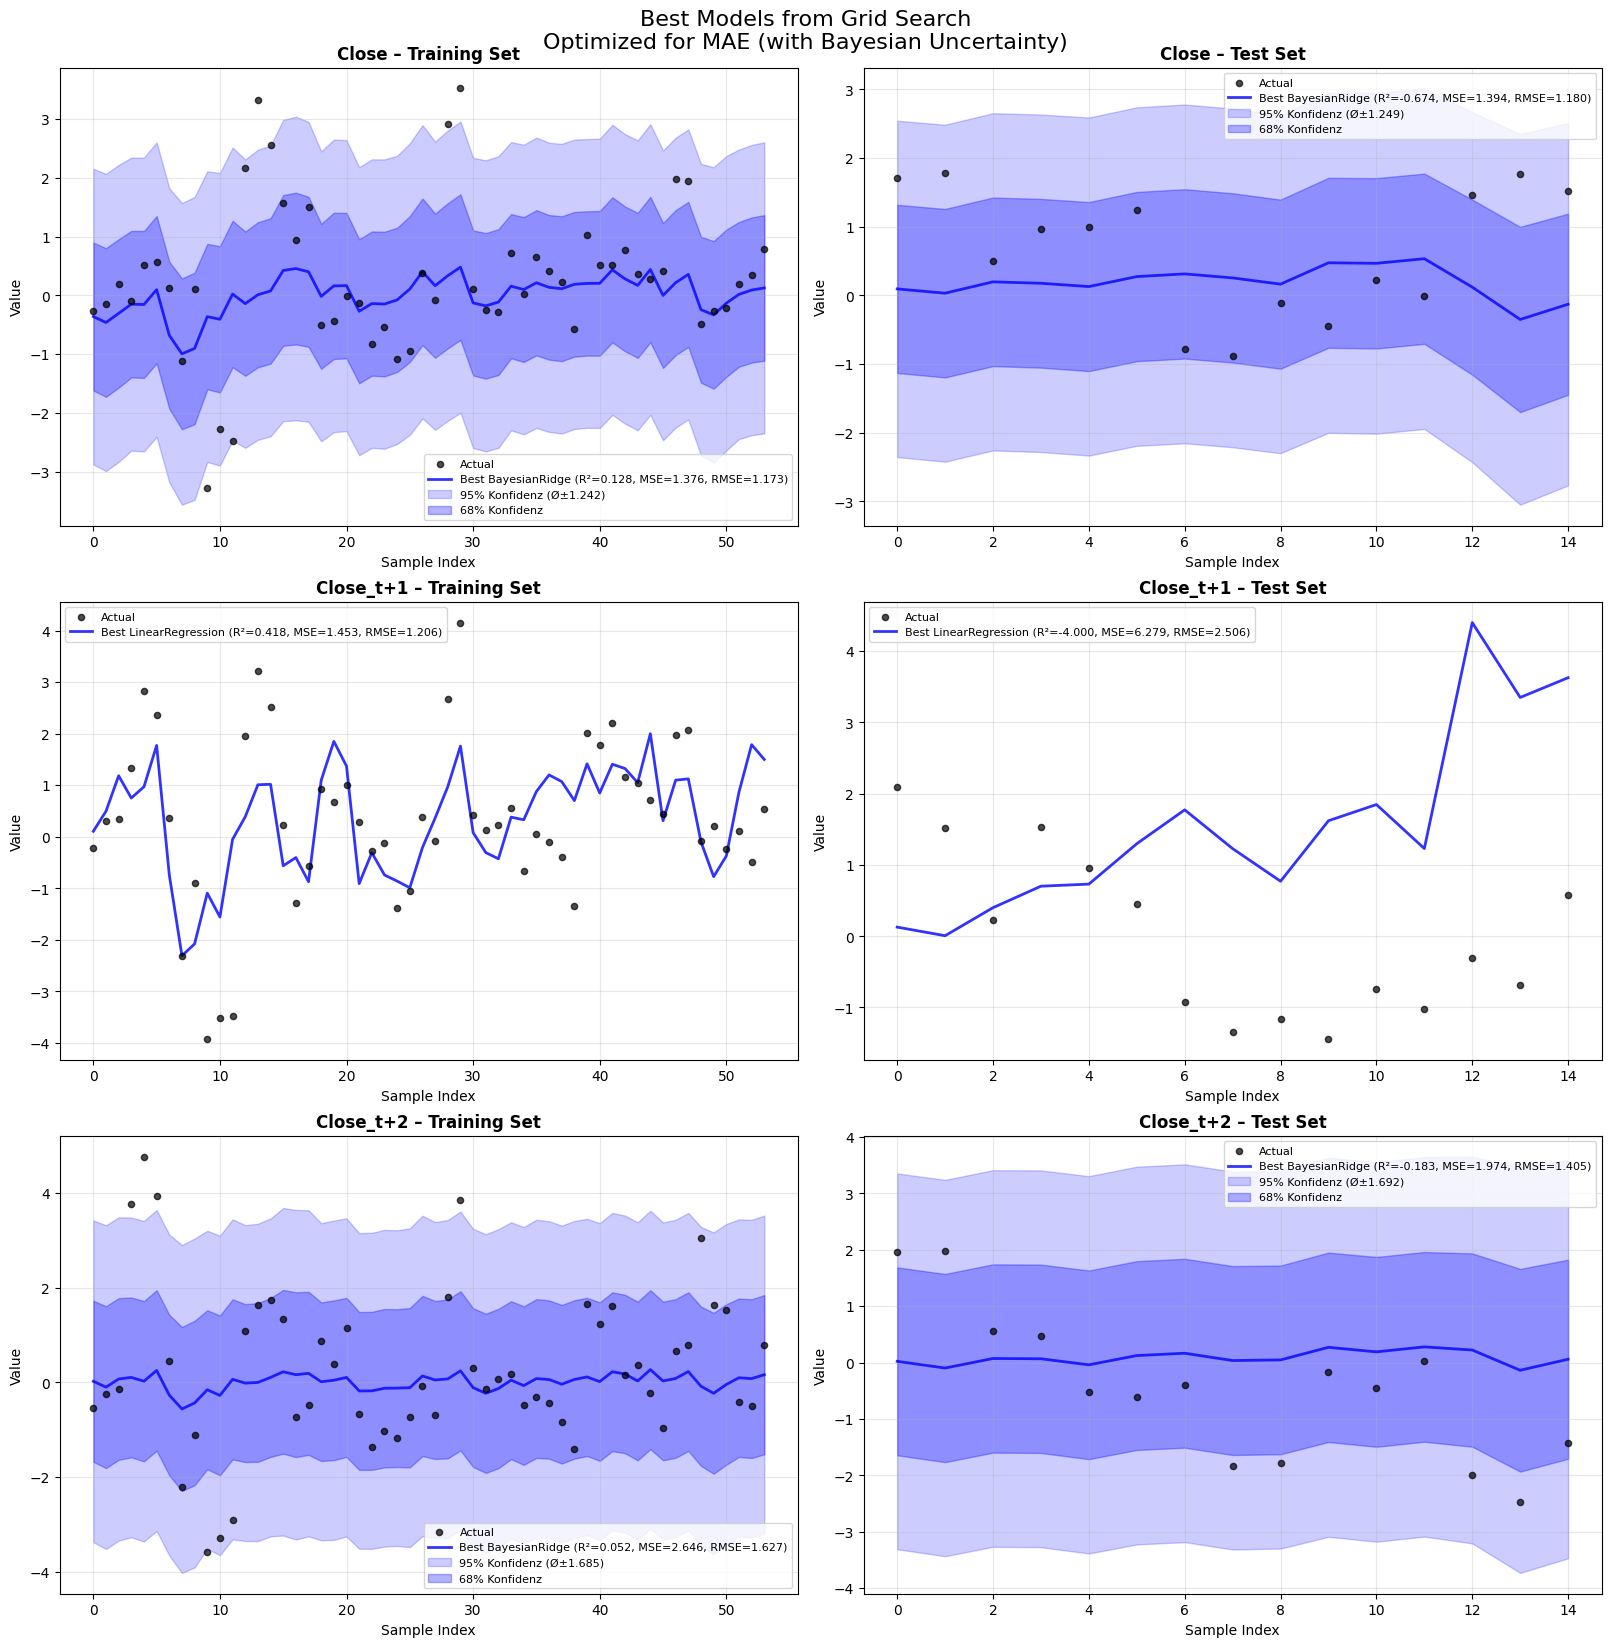

In [85]:
#neu Visualiesierung MAE
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

# --------------------------------------------------------------------------------
# ASSUMPTION: You have these DataFrames already in your notebook:
#   train_set, test_set, df_results (from the training code)
# --------------------------------------------------------------------------------

# 1. Define target and features
target_columns = ['Close', 'Close_t+1', 'Close_t+2']
feature_columns = [c for c in train_set.columns if c not in target_columns]

# 2. Prepare and scale features
X_train = train_set[feature_columns].values
X_test  = test_set[feature_columns].values
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 3. Prepare target arrays
y_train = {t: train_set[t].values for t in target_columns}
y_test  = {t: test_set[t].values  for t in target_columns}

# 4. Extract best parameters from df_results
# Get the best model for each target (lowest CV_MAE)
best_params = {}
model_classes = {
    'LinearRegression': LinearRegression,
    'Ridge': Ridge,
    'BayesianRidge': BayesianRidge
}

for target in target_columns:
    # Filter results for this target and find best model
    target_results = df_results[df_results['Target'] == target]
    best_row = target_results.loc[target_results['CV_MAE'].idxmin()]
    
    best_params[target] = {
        'model_name': best_row['Model'],
        'params': best_row['Best_Params']
    }

# 5. Train models and collect results
all_results = []

for target in target_columns:
    y_tr = y_train[target]
    y_te = y_test[target]
    
    target_results = {'target': target, 'y_train': y_tr, 'y_test': y_te, 'predictions': {}}
    
    # Get best model info for this target
    model_info = best_params[target]
    model_name = model_info['model_name']
    params = model_info['params']
    
    # Create and train the best model
    model_class = model_classes[model_name]
    model = model_class(**params)
    model.fit(X_train_scaled, y_tr)
    
    # Make predictions with uncertainty estimation for BayesianRidge
    if model_name == 'BayesianRidge':
        # Predictions with uncertainty
        pred_train, pred_train_std = model.predict(X_train_scaled, return_std=True)
        pred_test, pred_test_std = model.predict(X_test_scaled, return_std=True)
        
        # Store uncertainty information
        has_uncertainty = True
        train_std = pred_train_std
        test_std = pred_test_std
        
        # Calculate average uncertainty
        avg_train_std = np.mean(pred_train_std)
        avg_test_std = np.mean(pred_test_std)
    else:
        # Normal predictions for other models
        pred_train = model.predict(X_train_scaled)
        pred_test = model.predict(X_test_scaled)
        
        has_uncertainty = False
        train_std = None
        test_std = None
        avg_train_std = None
        avg_test_std = None
    
    # Calculate metrics
    train_r2 = r2_score(y_tr, pred_train)
    test_r2 = r2_score(y_te, pred_test)
    train_mse = mean_squared_error(y_tr, pred_train)
    test_mse = mean_squared_error(y_te, pred_test)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    
    target_results['predictions']['BEST'] = {
        'model_name': model_name,
        'train_pred': pred_train,
        'test_pred': pred_test,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'has_uncertainty': has_uncertainty,
        'train_std': train_std,
        'test_std': test_std,
        'avg_train_std': avg_train_std,
        'avg_test_std': avg_test_std
    }
    
    all_results.append(target_results)

# 6. Create visualization
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 16), constrained_layout=True)

for i, result in enumerate(all_results):
    target = result['target']
    y_tr = result['y_train']
    y_te = result['y_test']
    
    # Training plot
    ax_train = axes[i, 0]
    N_train = len(y_tr)
    ax_train.scatter(np.arange(N_train), y_tr, label='Actual', s=20, color='black', zorder=3, alpha=0.7)
    
    pred_data = result['predictions']['BEST']
    pred_train = pred_data['train_pred']
    r2_train = pred_data['train_r2']
    mse_train = pred_data['train_mse']
    rmse_train = pred_data['train_rmse']
    model_name = pred_data['model_name']
    
    # Plot predictions
    ax_train.plot(np.arange(N_train), pred_train, 
                 label=f"Best {model_name} (R²={r2_train:.3f}, MSE={mse_train:.3f}, RMSE={rmse_train:.3f})", 
                 color='blue', linestyle='-', linewidth=2, alpha=0.8)
    
    # Add uncertainty bands for BayesianRidge
    if pred_data['has_uncertainty']:
        train_std = pred_data['train_std']
        avg_std = pred_data['avg_train_std']
        
        # 95% confidence interval (±2σ)
        ax_train.fill_between(np.arange(N_train), 
                             pred_train - 2*train_std, 
                             pred_train + 2*train_std, 
                             alpha=0.2, color='blue', 
                             label=f'95% Konfidenz (Ø±{avg_std:.3f})')
        
        # 68% confidence interval (±1σ)
        ax_train.fill_between(np.arange(N_train), 
                             pred_train - train_std, 
                             pred_train + train_std, 
                             alpha=0.3, color='blue', 
                             label=f'68% Konfidenz')
    
    ax_train.set_title(f"{target} – Training Set", fontsize=12, fontweight='bold')
    ax_train.set_xlabel("Sample Index")
    ax_train.set_ylabel("Value")
    ax_train.grid(alpha=0.3)
    ax_train.legend(fontsize=8, loc='best')
    
    # Test plot
    ax_test = axes[i, 1]
    N_test = len(y_te)
    ax_test.scatter(np.arange(N_test), y_te, label='Actual', s=20, color='black', zorder=3, alpha=0.7)
    
    pred_test = pred_data['test_pred']
    r2_test = pred_data['test_r2']
    mse_test = pred_data['test_mse']
    rmse_test = pred_data['test_rmse']
    
    # Plot predictions
    ax_test.plot(np.arange(N_test), pred_test, 
                label=f"Best {model_name} (R²={r2_test:.3f}, MSE={mse_test:.3f}, RMSE={rmse_test:.3f})", 
                color='blue', linestyle='-', linewidth=2, alpha=0.8)
    
    # Add uncertainty bands for BayesianRidge
    if pred_data['has_uncertainty']:
        test_std = pred_data['test_std']
        avg_std = pred_data['avg_test_std']
        
        # 95% confidence interval (±2σ)
        ax_test.fill_between(np.arange(N_test), 
                            pred_test - 2*test_std, 
                            pred_test + 2*test_std, 
                            alpha=0.2, color='blue', 
                            label=f'95% Konfidenz (Ø±{avg_std:.3f})')
        
        # 68% confidence interval (±1σ)
        ax_test.fill_between(np.arange(N_test), 
                            pred_test - test_std, 
                            pred_test + test_std, 
                            alpha=0.3, color='blue', 
                            label=f'68% Konfidenz')
    
    ax_test.set_title(f"{target} – Test Set", fontsize=12, fontweight='bold')
    ax_test.set_xlabel("Sample Index")
    ax_test.set_ylabel("Value")
    ax_test.grid(alpha=0.3)
    ax_test.legend(fontsize=8, loc='best')

# Overall title
plt.suptitle("Best Models from Grid Search\nOptimized for MAE (with Bayesian Uncertainty)", 
             fontsize=16, y=1.02)
plt.show()


In [87]:
#Extensiv Run Baysian Ridge Parameter : 
#{'n_iter': 1, 'tol': 1e-07, 'alpha_1': 1e-06, 'alpha_2': 1e-05, 'lambda_1': 1e-05, 'lambda_2': 1e-05, 'alpha_init': 0.01, 'lambda_init': None, 'fit_intercept': False}
import numpy as np
import pandas as pd
from joblib import dump
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Define target and feature columns
target_columns = ['Close', 'Close_t+1', 'Close_t+2']
feature_columns = [col for col in train_set.columns if col not in target_columns]

# Prepare data arrays
X_train = train_set[feature_columns].values
X_test = test_set[feature_columns].values

# Create target dictionaries
y_train_dict = {t: train_set[t].values for t in target_columns}
y_test_dict = {t: test_set[t].values for t in target_columns}

# Calculate baseline statistics
baseline_stats = {}
for t in target_columns:
    y_tr, y_te = y_train_dict[t], y_test_dict[t]
    y_mean = np.mean(y_tr)
    
    baseline_stats[t] = {
        'train_mse': mean_squared_error(y_tr, np.full_like(y_tr, y_mean)),
        'test_mse': mean_squared_error(y_te, np.full_like(y_te, y_mean)),
        'train_r2': r2_score(y_tr, np.full_like(y_tr, y_mean)),
        'test_r2': r2_score(y_te, np.full_like(y_te, y_mean))
    }

# Scale features
scaler = StandardScaler()

# Define parameter grids for models
param_grids = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {
            'fit_intercept': [True, False]
        }
    },
    'BayesianRidge': {
        'model': BayesianRidge(),
        'params': {
            'n_iter': np.linspace(1,1, dtype=int),
            'tol': np.logspace(-7, -6, 2),
            'alpha_1': np.logspace(-6, -5, 2),
            'alpha_2': np.logspace(-6, -5, 2),
            'lambda_1': np.logspace(-6, -5, 2),
            'lambda_2': np.logspace(-6, -5, 2),
            'alpha_init': [ 1.0, 0.1,0.01],
            'lambda_init': [None, 0.1, 0.01],
            'fit_intercept': [ False]
        }
    }
}

# Define single-metric scoring - CHANGED TO MSE
scoring = 'neg_mean_squared_error'

# Initialize results list
results = []

# Main grid search loop with MSE metric only
for target in target_columns:
    y_tr, y_te = y_train_dict[target], y_test_dict[target]
    bl = baseline_stats[target]
    
    for name, cfg in param_grids.items():
        # Configure and run grid search with MSE metric only
        grid = GridSearchCV(
            estimator=cfg['model'],
            param_grid=cfg['params'],
            scoring=scoring,
            cv=KFold(n_splits=9, shuffle=False),
            verbose=1,
            n_jobs=-1,
            return_train_score=True
        )
        
        # Perform hyperparameter optimization using scaled features
        grid.fit(scaler.fit_transform(X_train), y_tr)
        
        # Extract best results
        cv_results = grid.cv_results_
        
        # Find best index for MSE metric
        best_idx = np.argmax(cv_results['mean_test_score'])  # argmax because values are negative
        cv_score = -cv_results['mean_test_score'][best_idx]  # Convert back to positive
        
        # Get best parameters
        best_params = {}
        for param_name in cfg['params'].keys():
            best_params[param_name] = cv_results[f'param_{param_name}'][best_idx]
        
        # Create model with best parameters
        best_model = cfg['model'].__class__(**best_params)
        best_model.fit(scaler.fit_transform(X_train), y_tr)
        
        # Calculate train/test metrics
        train_pred = best_model.predict(scaler.fit_transform(X_train))
        test_pred = best_model.predict(scaler.transform(X_test))
        
        train_mse = mean_squared_error(y_tr, train_pred)
        test_mse = mean_squared_error(y_te, test_pred)
        train_r2 = r2_score(y_tr, train_pred)
        test_r2 = r2_score(y_te, test_pred)
        
        # Format metrics with baseline
        train_mse_str = f"{train_mse:.4f} ({bl['train_mse']:.4f})"
        test_mse_str = f"{test_mse:.4f} ({bl['test_mse']:.4f})"
        train_r2_str = f"{train_r2:.4f} ({bl['train_r2']:.4f})"
        test_r2_str = f"{test_r2:.4f} ({bl['test_r2']:.4f})"
        
        # Store results - CHANGED CV_MAE to CV_MSE
        results.append({
            'Target': target,
            'Model': name,
            'CV_MSE': cv_score,
            'Train_MSE': train_mse_str,
            'Test_MSE': test_mse_str,
            'Train_R²': train_r2_str,
            'Test_R²': test_r2_str,
            'Best_Params': best_params
        })
        
        # Save the best model - CHANGED filename to reflect MSE
        dump(best_model, f"best_model_mse_{target}_cv9.joblib")

# Create DataFrame
df_results = pd.DataFrame(results)


Fitting 9 folds for each of 2 candidates, totalling 18 fits
Fitting 9 folds for each of 14400 candidates, totalling 129600 fits
Fitting 9 folds for each of 2 candidates, totalling 18 fits
Fitting 9 folds for each of 14400 candidates, totalling 129600 fits
Fitting 9 folds for each of 2 candidates, totalling 18 fits
Fitting 9 folds for each of 14400 candidates, totalling 129600 fits


In [90]:
#MSE werte
import pandas as pd
from IPython.display import FileLink

# CONFIG - Set your desired filename and title here
EXCEL_FILENAME = "grid_search_results_regularisation_model_bayesian_wahl_PARAMETER_MSE_.xlsx"
TABLE_TITLE = "GRID SEARCH - BEST RUN PER TARGET (BEST ROW IN BOLD)"

# Define target order
target_columns = ['Close', 'Close_t+1', 'Close_t+2']
df_results['Target'] = pd.Categorical(df_results['Target'], categories=target_columns, ordered=True)

# Sort by Target, then by best CV_MSE
df_sorted = df_results.sort_values(['Target', 'CV_MSE']).reset_index(drop=True)

# Round numerical columns to 3 decimal places
numerical_cols = ['CV_MSE']
for col in numerical_cols:
    df_sorted[col] = df_sorted[col].round(3)

# Function to extract and round values from formatted strings
def extract_and_round_values(formatted_str):
    """Extract main value and baseline from formatted string like '1.4036 (1.5769)'"""
    parts = formatted_str.split(' (')
    main_val = round(float(parts[0]), 3)
    baseline_val = round(float(parts[1].rstrip(')')), 3)
    return f"{main_val:.3f} ({baseline_val:.3f})"

# Apply rounding to formatted metric columns
metric_cols = ['Train_MSE', 'Test_MSE', 'Train_R²', 'Test_R²']
for col in metric_cols:
    df_sorted[col] = df_sorted[col].apply(extract_and_round_values)

# Define column headers for display
headers = ['Target', 'Model', 'CV_MSE', 'Train_MSE', 'Test_MSE', 'Train_R²', 'Test_R²', 'Best_Params']

# Grouped and formatted output with empty line between targets
print(f"\n{TABLE_TITLE}")
print("="*120)

# Print headers
header_str = ""
for header in headers:
    header_str += f"{header:<15}"
print(header_str)
print("-" * 120)

for target in target_columns:
    group = df_sorted[df_sorted['Target'] == target]
    if not group.empty:
        # Bold marking of best row
        idx_best = group['CV_MSE'].idxmin()
        for i, row in group.iterrows():
            row_str = ""
            for col in headers:
                val = str(row[col])
                if i == idx_best:
                    row_str += f"\033[1m{val:<15}\033[0m"  # Bold for console
                else:
                    row_str += f"{val:<15}"
            print(row_str)
        print()  # Empty line between targets

# Prepare DataFrame for Excel export (only selected columns)
df_export = df_sorted[headers].copy()

# Save DataFrame to Excel file with title
print(f"\nSaving results to {EXCEL_FILENAME}...")
with pd.ExcelWriter(EXCEL_FILENAME, engine='openpyxl') as writer:
    # Write title in first row
    title_df = pd.DataFrame([[TABLE_TITLE]], columns=[''])
    title_df.to_excel(writer, sheet_name='Results', index=False, header=False, startrow=0)
    
    # Write main data starting from row 2
    df_export.to_excel(writer, sheet_name='Results', index=False, startrow=2)

print(f"✓ File saved successfully!")

# Create download link for Kaggle
print(f"\n📁 Download your results:")
display(FileLink(EXCEL_FILENAME))

# For Jupyter/Kaggle: Optional display with Styler (bold in HTML)
try:
    from IPython.display import display
    styled = df_export.style
    for target in target_columns:
        mask = df_export['Target'] == target
        if mask.sum() > 0:
            idx = df_export.loc[mask, 'CV_MSE'].idxmin()
            styled = styled.apply(
                lambda x: ['font-weight: bold' if x.name == idx else '' for _ in x],
                axis=1
            )
    display(styled)
except ImportError:
    pass



GRID SEARCH - BEST RUN PER TARGET (BEST ROW IN BOLD)
Target         Model          CV_MSE         Train_MSE      Test_MSE       Train_R²       Test_R²        Best_Params    
------------------------------------------------------------------------------------------------------------------------
Close          BayesianRidge  1.627          1.255 (1.577)  1.349 (0.974)  0.204 (0.000)  -0.620 (-0.171){'n_iter': 1, 'tol': 1e-07, 'alpha_1': 1e-06, 'alpha_2': 1e-05, 'lambda_1': 1e-05, 'lambda_2': 1e-06, 'alpha_init': 0.1, 'lambda_init': None, 'fit_intercept': False}
Close          LinearRegression1.845          1.186 (1.577)  1.275 (0.974)  0.248 (0.000)  -0.531 (-0.171){'fit_intercept': False}

Close_t+1      BayesianRidge  2.289          1.615 (2.497)  4.095 (1.389)  0.353 (0.000)  -2.261 (-0.106){'n_iter': 1, 'tol': 1e-07, 'alpha_1': 1e-05, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 1e-05, 'alpha_init': 1.0, 'lambda_init': 0.01, 'fit_intercept': False}
Close_t+1      LinearRegressio

/kaggle/working/grid_search_results_regularisation_model_bayesian_wahl_PARAMETER_MSE_.xlsx

,Target,Model,CV_MSE,Train_MSE,Test_MSE,Train_R²,Test_R²,Best_Params
0,Close,BayesianRidge,1.627000,1.255 (1.577),1.349 (0.974),0.204 (0.000),-0.620 (-0.171),"{'n_iter': 1, 'tol': 1e-07, 'alpha_1': 1e-06, 'alpha_2': 1e-05, 'lambda_1': 1e-05, 'lambda_2': 1e-06, 'alpha_init': 0.1, 'lambda_init': None, 'fit_intercept': False}"
1,Close,LinearRegression,1.845000,1.186 (1.577),1.275 (0.974),0.248 (0.000),-0.531 (-0.171),{'fit_intercept': False}
2,Close_t+1,BayesianRidge,2.289000,1.615 (2.497),4.095 (1.389),0.353 (0.000),-2.261 (-0.106),"{'n_iter': 1, 'tol': 1e-07, 'alpha_1': 1e-05, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 1e-05, 'alpha_init': 1.0, 'lambda_init': 0.01, 'fit_intercept': False}"
3,Close_t+1,LinearRegression,2.305000,1.453 (2.497),6.279 (1.389),0.418 (0.000),-4.000 (-0.106),{'fit_intercept': True}
4,Close_t+2,BayesianRidge,3.187000,2.646 (2.792),1.974 (2.163),0.052 (0.000),-0.183 (-0.296),"{'n_iter': 1, 'tol': 1e-07, 'alpha_1': 1e-06, 'alpha_2': 1e-05, 'lambda_1': 1e-05, 'lambda_2': 1e-06, 'alpha_init': 0.01, 'lambda_init': None, 'fit_intercept': False}"
5,Close_t+2,LinearRegression,3.966000,2.017 (2.792),5.736 (2.163),0.278 (0.000),-2.437 (-0.296),{'fit_intercept': False}


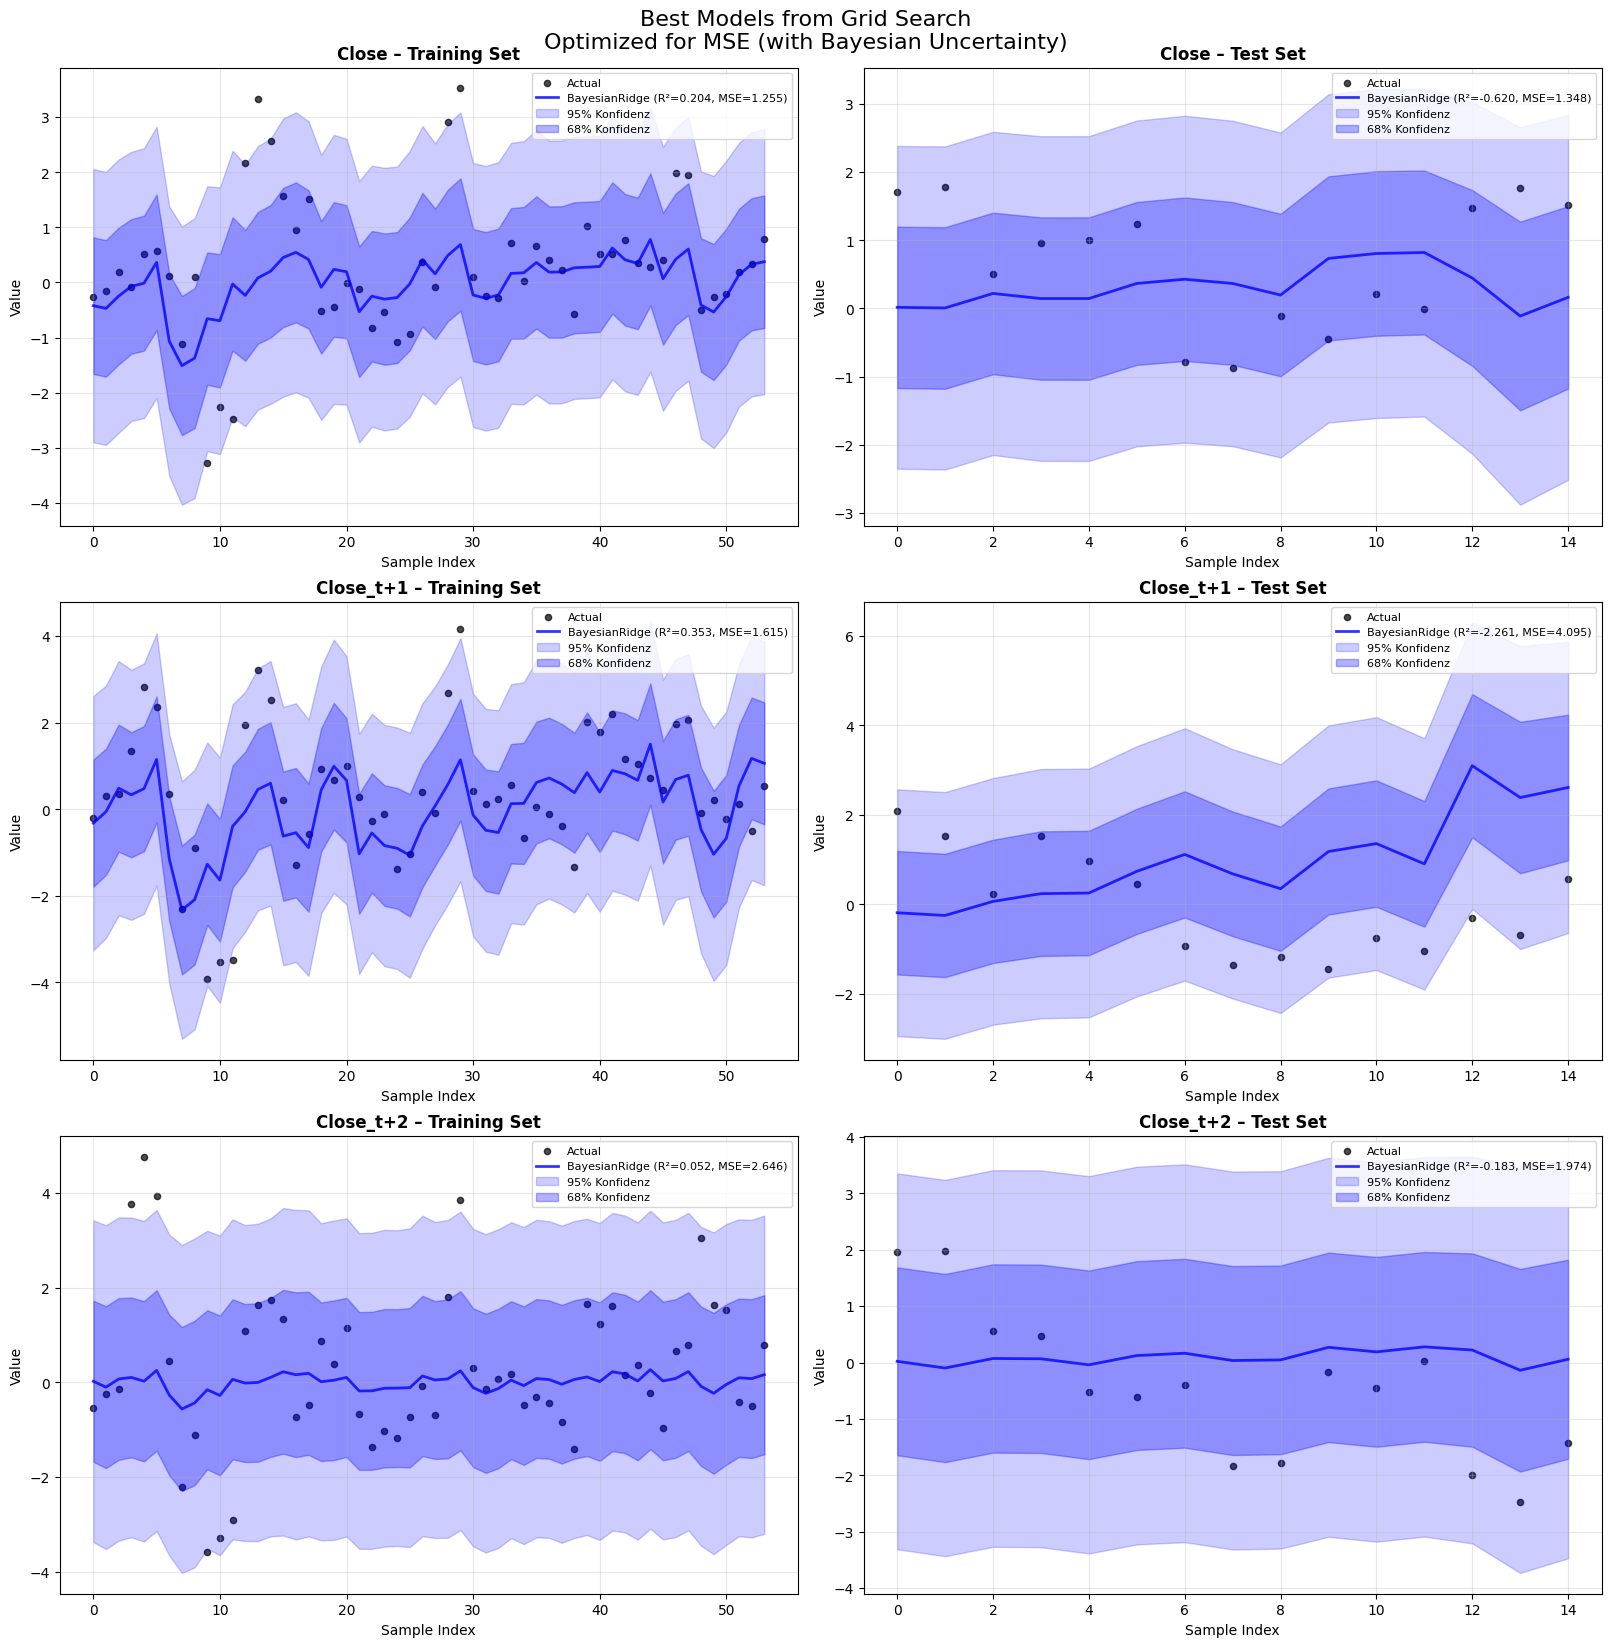

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

# 1. Define target and features
target_columns = ['Close', 'Close_t+1', 'Close_t+2']
feature_columns = [c for c in train_set.columns if c not in target_columns]

# 2. Prepare and scale features
X_train = train_set[feature_columns].values
X_test = test_set[feature_columns].values
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Prepare target arrays
y_train = {t: train_set[t].values for t in target_columns}
y_test = {t: test_set[t].values for t in target_columns}

# 4. Extract best parameters from df_results
model_classes = {'LinearRegression': LinearRegression, 'BayesianRidge': BayesianRidge}
best_params = {}

for target in target_columns:
    target_results = df_results[df_results['Target'] == target]
    best_row = target_results.loc[target_results['CV_MSE'].idxmin()]
    best_params[target] = {
        'model_name': best_row['Model'],
        'params': best_row['Best_Params']
    }

# 5. Train models and create visualization
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 16), constrained_layout=True)

for i, target in enumerate(target_columns):
    y_tr, y_te = y_train[target], y_test[target]
    
    # Get best model and train
    model_info = best_params[target]
    model = model_classes[model_info['model_name']](**model_info['params'])
    model.fit(X_train_scaled, y_tr)
    
    # Make predictions
    if model_info['model_name'] == 'BayesianRidge':
        pred_train, train_std = model.predict(X_train_scaled, return_std=True)
        pred_test, test_std = model.predict(X_test_scaled, return_std=True)
        has_uncertainty = True
    else:
        pred_train = model.predict(X_train_scaled)
        pred_test = model.predict(X_test_scaled)
        has_uncertainty = False
    
    # Calculate metrics
    metrics = {
        'train_r2': r2_score(y_tr, pred_train),
        'test_r2': r2_score(y_te, pred_test),
        'train_mse': mean_squared_error(y_tr, pred_train),
        'test_mse': mean_squared_error(y_te, pred_test)
    }
    
    # Plot for both train and test
    for j, (data_type, y_data, pred_data) in enumerate([
        ('Training', y_tr, pred_train), 
        ('Test', y_te, pred_test)
    ]):
        ax = axes[i, j]
        N = len(y_data)
        
        # FIXED: Use correct key mapping
        key_prefix = 'train' if data_type == 'Training' else 'test'
        
        # Plot actual vs predicted
        ax.scatter(np.arange(N), y_data, label='Actual', s=20, color='black', alpha=0.7)
        ax.plot(np.arange(N), pred_data, 
               label=f"{model_info['model_name']} (R²={metrics[f'{key_prefix}_r2']:.3f}, MSE={metrics[f'{key_prefix}_mse']:.3f})", 
               color='blue', linewidth=2, alpha=0.8)
        
        # Add uncertainty bands for BayesianRidge
        if has_uncertainty:
            std_data = train_std if j == 0 else test_std
            ax.fill_between(np.arange(N), pred_data - 2*std_data, pred_data + 2*std_data, 
                           alpha=0.2, color='blue', label='95% Konfidenz')
            ax.fill_between(np.arange(N), pred_data - std_data, pred_data + std_data, 
                           alpha=0.3, color='blue', label='68% Konfidenz')
        
        ax.set_title(f"{target} – {data_type} Set", fontsize=12, fontweight='bold')
        ax.set_xlabel("Sample Index")
        ax.set_ylabel("Value")
        ax.grid(alpha=0.3)
        ax.legend(fontsize=8, loc='best')

plt.suptitle("Best Models from Grid Search\nOptimized for MSE (with Bayesian Uncertainty)", 
             fontsize=16, y=1.02)
plt.show()


# Bayesian gewählt

Param_Set_2:
------------------------------------------------------------
  n_iter: 1
  tol: 1e-07
  alpha_1: 1e-06
  alpha_2: 1e-05
  lambda_1: 1e-05
  lambda_2: 1e-06
  alpha_init: 0.1
  lambda_init: None
  fit_intercept: False

# Auswahl Sentiment Art

In [4]:
#DATASETs erstellen
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# Konfiguration für Train/Test-Split
config = {
    'use_fixed_testset': False,
    'test_size': 15,
    'random_state': 33,
    'fixed_test_dates': [
        '2024-01-25',
        '2023-05-04',
        '2023-02-02',
        '2025-03-06',
        '2024-10-17'
    ]
}

# Train/Test Split Logik (basierend auf df_base)
if config['use_fixed_testset']:
    test_dates = pd.to_datetime(config['fixed_test_dates'])
    test_indices = df_base.index.isin(test_dates)
    train_indices = ~test_indices
else:
    np.random.seed(config['random_state'])
    unique_dates = df_base.index.normalize().unique()
    n_dates = config['test_size'] // 3
    
    dates_zero = []
    dates_positive = []
    dates_negative = []
    
    for date in unique_dates:
        values = df_base.loc[df_base.index.normalize() == date, 'Interest Rate_Change']
        if (values == 0.00).any():
            dates_zero.append(date)
        if (values > 0.00).any():
            dates_positive.append(date)
        if (values < 0.00).any():
            dates_negative.append(date)
    
    selected_dates = []
    selected_dates.append(np.random.choice(dates_zero))
    selected_dates.append(np.random.choice(dates_positive))
    selected_dates.append(np.random.choice(dates_negative))
    
    remaining = [d for d in unique_dates if d not in selected_dates]
    if n_dates > 3:
        additional = np.random.choice(remaining, size=n_dates-3, replace=False)
        selected_dates.extend(additional)
    
    test_indices = df_base.index.normalize().isin(selected_dates)
    train_indices = ~test_indices

# Alle DataFrames aufteilen
train_set = df_base.loc[train_indices]
test_set = df_base.loc[test_indices]

train_fin_sen = df_fin_sen.loc[train_indices]
test_fin_sen = df_fin_sen.loc[test_indices]

train_fin_chk = df_fin_chk.loc[train_indices]
test_fin_chk = df_fin_chk.loc[test_indices]

train_rob_sen = df_rob_sen.loc[train_indices]
test_rob_sen = df_rob_sen.loc[test_indices]

train_rob_chk = df_rob_chk.loc[train_indices]
test_rob_chk = df_rob_chk.loc[test_indices]

# Ausgabe der Shapes
datasets = [
    ('base', train_set, test_set),
    ('fin_sen', train_fin_sen, test_fin_sen),
    ('fin_chk', train_fin_chk, test_fin_chk),
    ('rob_sen', train_rob_sen, test_rob_sen),
    ('rob_chk', train_rob_chk, test_rob_chk)
]

for name, train, test in datasets:
    print(f"{name} - Train-Set Shape: {train.shape}")
    print(f"{name} - Test-Set  Shape: {test.shape}")


base - Train-Set Shape: (54, 10)
base - Test-Set  Shape: (15, 10)
fin_sen - Train-Set Shape: (54, 11)
fin_sen - Test-Set  Shape: (15, 11)
fin_chk - Train-Set Shape: (54, 11)
fin_chk - Test-Set  Shape: (15, 11)
rob_sen - Train-Set Shape: (54, 11)
rob_sen - Test-Set  Shape: (15, 11)
rob_chk - Train-Set Shape: (54, 11)
rob_chk - Test-Set  Shape: (15, 11)


In [19]:
#CV mit MSE
import numpy as np
import pandas as pd
from joblib import dump
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold

# ANSI escape codes for bold text
BOLD = "\033[1m"
ENDC = "\033[0m"

# Define target columns
target_columns = ['Close', 'Close_t+1', 'Close_t+2']

# Define datasets
datasets = {
    'base':    {'train': train_set,     'test': test_set},
    'fin_sen': {'train': train_fin_sen, 'test': test_fin_sen},
    'fin_chk': {'train': train_fin_chk, 'test': test_fin_chk},
    'rob_sen': {'train': train_rob_sen, 'test': test_rob_sen},
    'rob_chk': {'train': train_rob_chk, 'test': test_rob_chk}
}

# Target-specific Bayesian Ridge parameters
target_params = {
    'Close':    {'n_iter':1,'tol':1e-07,'alpha_1':1e-06,'alpha_2':1e-05,'lambda_1':1e-05,'lambda_2':1e-06,'alpha_init':0.1,'lambda_init':None,'fit_intercept':False},
    'Close_t+1':{'n_iter':1,'tol':1e-07,'alpha_1':1e-05,'alpha_2':1e-06,'lambda_1':1e-06,'lambda_2':1e-05,'alpha_init':1.0,'lambda_init':0.01,'fit_intercept':False},
    'Close_t+2':{'n_iter':1,'tol':1e-07,'alpha_1':1e-06,'alpha_2':1e-05,'lambda_1':1e-05,'lambda_2':1e-06,'alpha_init':0.01,'lambda_init':None,'fit_intercept':False}
}

# Scale all feature sets once
for name, data in datasets.items():
    X = data['train'].drop(columns=target_columns).values
    scaler = StandardScaler().fit(X)
    datasets[name]['X_train_scaled'] = scaler.transform(X)
    datasets[name]['X_test_scaled']  = scaler.transform(
        data['test'].drop(columns=target_columns).values
    )

cv = KFold(n_splits=9, shuffle=False)
results = []

for ds_name, data in datasets.items():
    X_train = data['X_train_scaled']
    X_test  = data['X_test_scaled']
    y_train = {t: data['train'][t].values for t in target_columns}
    y_test  = {t: data['test'][t].values  for t in target_columns}

    # Baseline metrics
    baseline = {}
    for t in target_columns:
        y_tr, y_te = y_train[t], y_test[t]
        m = np.mean(y_tr)
        baseline[t] = {
            'train_mse': mean_squared_error(y_tr, np.full_like(y_tr, m)),
            'test_mse':  mean_squared_error(y_te, np.full_like(y_te, m)),
            'train_r2':  r2_score(y_tr, np.full_like(y_tr, m)),
            'test_r2':   r2_score(y_te, np.full_like(y_te, m))
        }

    for target in target_columns:
        y_tr, y_te = y_train[target], y_test[target]
        bl = baseline[target]
        
        # Use target-specific parameters
        model = BayesianRidge(**target_params[target])
        
        # Cross-validation with fixed parameters
        cv_scores = cross_val_score(
            model, X_train, y_tr, 
            cv=cv, 
            scoring='neg_mean_squared_error', 
            n_jobs=-1
        )
        cv_mse = -cv_scores.mean()

        # Fit and predict
        model.fit(X_train, y_tr)
        tr_pred = model.predict(X_train)
        te_pred = model.predict(X_test)

        tr_mse = mean_squared_error(y_tr, tr_pred)
        te_mse = mean_squared_error(y_te, te_pred)
        tr_r2  = r2_score(y_tr, tr_pred)
        te_r2  = r2_score(y_te, te_pred)

        results.append({
            'Target':      target,
            'Feature_Set': ds_name,
            'CV_MSE':      cv_mse,
            'Train_MSE':   f"{tr_mse:.4f} ({bl['train_mse']:.4f})",
            'Test_MSE':    f"{te_mse:.4f} ({bl['test_mse']:.4f})",
            'Train_R²':    f"{tr_r2:.4f} ({bl['train_r2']:.4f})",
            'Test_R²':     f"{te_r2:.4f} ({bl['test_r2']:.4f})",
            'Parameters':  target_params[target]
        })

        dump(model, f"best_model_{ds_name}_{target}.joblib")

df = pd.DataFrame(results)

# Identify best Feature_Set per Target by CV_MSE
best_indices = df.groupby('Target')['CV_MSE'].idxmin().tolist()

# Sort and print with blank lines between Targets
print("\nFIXED PARAMETERS - BEST RUN PER TARGET (BEST ROW IN BOLD)")
print("="*120)
header = f"{'Target':<12}{'Feature_Set':<15}{'CV_MSE':<12}{'Train_MSE':<20}{'Test_MSE':<20}{'Train_R²':<20}{'Test_R²':<20}"
print(header)
print("-"*120)

current_target = None
for i, row in df.sort_values(['Target', 'CV_MSE']).iterrows():
    # Blank line when target category changes
    if current_target is not None and row['Target'] != current_target:
        print()
    current_target = row['Target']

    line = (
        f"{row['Target']:<12}"
        f"{row['Feature_Set']:<15}"
        f"{row['CV_MSE']:<12.4f}"
        f"{row['Train_MSE']:<20}"
        f"{row['Test_MSE']:<20}"
        f"{row['Train_R²']:<20}"
        f"{row['Test_R²']:<20}"
    )

    # Bold the best run row
    if i in best_indices:
        print(f"{BOLD}{line}{ENDC}")
    else:
        print(line)



FIXED PARAMETERS - BEST RUN PER TARGET (BEST ROW IN BOLD)
Target      Feature_Set    CV_MSE      Train_MSE           Test_MSE            Train_R²            Test_R²             
------------------------------------------------------------------------------------------------------------------------
Close       fin_sen        1.5689      1.1718 (1.5769)     1.4287 (0.9743)     0.2569 (0.0000)     -0.7165 (-0.1706)   
Close       fin_chk        1.6267      1.1858 (1.5769)     1.3003 (0.9743)     0.2481 (0.0000)     -0.5622 (-0.1706)   
Close       base           1.6269      1.2547 (1.5769)     1.3485 (0.9743)     0.2043 (0.0000)     -0.6201 (-0.1706)   
Close       rob_chk        1.6751      1.1586 (1.5769)     1.3637 (0.9743)     0.2653 (0.0000)     -0.6384 (-0.1706)   
Close       rob_sen        1.6790      1.1805 (1.5769)     1.5721 (0.9743)     0.2514 (0.0000)     -0.8887 (-0.1706)   

Close_t+1   base           2.2885      1.6147 (2.4972)     4.0952 (1.3888)     0.3534 (0.0000)     

In [21]:
#CV mit RMSE
import numpy as np
import pandas as pd
from joblib import dump
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold

# ANSI escape codes for bold text
BOLD = "\033[1m"
ENDC = "\033[0m"

# Define target columns
target_columns = ['Close', 'Close_t+1', 'Close_t+2']

# Define datasets
datasets = {
    'base':    {'train': train_set,     'test': test_set},
    'fin_sen': {'train': train_fin_sen, 'test': test_fin_sen},
    'fin_chk': {'train': train_fin_chk, 'test': test_fin_chk},
    'rob_sen': {'train': train_rob_sen, 'test': test_rob_sen},
    'rob_chk': {'train': train_rob_chk, 'test': test_rob_chk}
}

# Target-specific Bayesian Ridge parameters
target_params = {
    'Close':    {'n_iter':1,'tol':1e-07,'alpha_1':1e-06,'alpha_2':1e-05,'lambda_1':1e-05,'lambda_2':1e-06,'alpha_init':0.1,'lambda_init':None,'fit_intercept':False},
    'Close_t+1':{'n_iter':1,'tol':1e-07,'alpha_1':1e-05,'alpha_2':1e-06,'lambda_1':1e-06,'lambda_2':1e-05,'alpha_init':1.0,'lambda_init':0.01,'fit_intercept':False},
    'Close_t+2':{'n_iter':1,'tol':1e-07,'alpha_1':1e-06,'alpha_2':1e-05,'lambda_1':1e-05,'lambda_2':1e-06,'alpha_init':0.01,'lambda_init':None,'fit_intercept':False}
}

# Scale all feature sets once
for name, data in datasets.items():
    X = data['train'].drop(columns=target_columns).values
    scaler = StandardScaler().fit(X)
    datasets[name]['X_train_scaled'] = scaler.transform(X)
    datasets[name]['X_test_scaled']  = scaler.transform(
        data['test'].drop(columns=target_columns).values
    )

cv = KFold(n_splits=9, shuffle=False)
results = []

for ds_name, data in datasets.items():
    X_train = data['X_train_scaled']
    X_test  = data['X_test_scaled']
    y_train = {t: data['train'][t].values for t in target_columns}
    y_test  = {t: data['test'][t].values  for t in target_columns}

    # Baseline metrics
    baseline = {}
    for t in target_columns:
        y_tr, y_te = y_train[t], y_test[t]
        m = np.mean(y_tr)
        baseline[t] = {
            'train_mse': mean_squared_error(y_tr, np.full_like(y_tr, m)),
            'test_mse':  mean_squared_error(y_te, np.full_like(y_te, m)),
            'train_r2':  r2_score(y_tr, np.full_like(y_tr, m)),
            'test_r2':   r2_score(y_te, np.full_like(y_te, m))
        }

    for target in target_columns:
        y_tr, y_te = y_train[target], y_test[target]
        bl = baseline[target]
        
        # Use target-specific parameters
        model = BayesianRidge(**target_params[target])
        
        # Cross-validation with fixed parameters
        cv_scores = cross_val_score(
            model, X_train, y_tr, 
            cv=cv, 
            scoring='neg_root_mean_squared_error', 
            n_jobs=-1
        )
        cv_rmse = -cv_scores.mean()

        # Fit and predict
        model.fit(X_train, y_tr)
        tr_pred = model.predict(X_train)
        te_pred = model.predict(X_test)

        tr_mse = mean_squared_error(y_tr, tr_pred)
        te_mse = mean_squared_error(y_te, te_pred)
        tr_r2  = r2_score(y_tr, tr_pred)
        te_r2  = r2_score(y_te, te_pred)

        results.append({
            'Target':      target,
            'Feature_Set': ds_name,
            'CV_RMSE':     cv_rmse,
            'Train_MSE':   f"{tr_mse:.4f} ({bl['train_mse']:.4f})",
            'Test_MSE':    f"{te_mse:.4f} ({bl['test_mse']:.4f})",
            'Train_R²':    f"{tr_r2:.4f} ({bl['train_r2']:.4f})",
            'Test_R²':     f"{te_r2:.4f} ({bl['test_r2']:.4f})",
            'Parameters':  target_params[target]
        })

        dump(model, f"best_model_{ds_name}_{target}.joblib")

df = pd.DataFrame(results)

# Identify best Feature_Set per Target by CV_RMSE
best_indices = df.groupby('Target')['CV_RMSE'].idxmin().tolist()

# Sort and print with blank lines between Targets
print("\nFIXED PARAMETERS - BEST RUN PER TARGET (BEST ROW IN BOLD)")
print("="*120)
header = f"{'Target':<12}{'Feature_Set':<15}{'CV_RMSE':<12}{'Train_MSE':<20}{'Test_MSE':<20}{'Train_R²':<20}{'Test_R²':<20}"
print(header)
print("-"*120)

current_target = None
for i, row in df.sort_values(['Target', 'CV_RMSE']).iterrows():
    # Blank line when target category changes
    if current_target is not None and row['Target'] != current_target:
        print()
    current_target = row['Target']

    line = (
        f"{row['Target']:<12}"
        f"{row['Feature_Set']:<15}"
        f"{row['CV_RMSE']:<12.4f}"
        f"{row['Train_MSE']:<20}"
        f"{row['Test_MSE']:<20}"
        f"{row['Train_R²']:<20}"
        f"{row['Test_R²']:<20}"
    )

    # Bold the best run row
    if i in best_indices:
        print(f"{BOLD}{line}{ENDC}")
    else:
        print(line)



FIXED PARAMETERS - BEST RUN PER TARGET (BEST ROW IN BOLD)
Target      Feature_Set    CV_RMSE     Train_MSE           Test_MSE            Train_R²            Test_R²             
------------------------------------------------------------------------------------------------------------------------
Close       base           1.0195      1.2547 (1.5769)     1.3485 (0.9743)     0.2043 (0.0000)     -0.6201 (-0.1706)   
Close       rob_chk        1.0633      1.1586 (1.5769)     1.3637 (0.9743)     0.2653 (0.0000)     -0.6384 (-0.1706)   
Close       fin_sen        1.0654      1.1718 (1.5769)     1.4287 (0.9743)     0.2569 (0.0000)     -0.7165 (-0.1706)   
Close       fin_chk        1.0686      1.1858 (1.5769)     1.3003 (0.9743)     0.2481 (0.0000)     -0.5622 (-0.1706)   
Close       rob_sen        1.0750      1.1805 (1.5769)     1.5721 (0.9743)     0.2514 (0.0000)     -0.8887 (-0.1706)   

Close_t+1   base           1.4167      1.6147 (2.4972)     4.0952 (1.3888)     0.3534 (0.0000)     

# FinBert mit Sentence gewählt

In [9]:
import numpy as np
import pandas as pd
from joblib import dump
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold

# ANSI escape codes for bold text
BOLD = "\033[1m"
ENDC = "\033[0m"

# Define target columns
target_columns = ['Close', 'Close_t+1', 'Close_t+2']

# Define datasets
datasets = {
    'base':    {'train': train_set,     'test': test_set},
    'fin_sen': {'train': train_fin_sen, 'test': test_fin_sen}
}

# Target-specific Bayesian Ridge parameters
target_params = {
    'Close':    {'n_iter':1,'tol':1e-07,'alpha_1':1e-06,'alpha_2':1e-05,'lambda_1':1e-05,'lambda_2':1e-06,'alpha_init':0.1,'lambda_init':None,'fit_intercept':False},
    'Close_t+1':{'n_iter':1,'tol':1e-07,'alpha_1':1e-05,'alpha_2':1e-06,'lambda_1':1e-06,'lambda_2':1e-05,'alpha_init':1.0,'lambda_init':0.01,'fit_intercept':False},
    'Close_t+2':{'n_iter':1,'tol':1e-07,'alpha_1':1e-06,'alpha_2':1e-05,'lambda_1':1e-05,'lambda_2':1e-06,'alpha_init':0.01,'lambda_init':None,'fit_intercept':False}
}

# Scale all feature sets once
for name, data in datasets.items():
    X = data['train'].drop(columns=target_columns).values
    scaler = StandardScaler().fit(X)
    datasets[name]['X_train_scaled'] = scaler.transform(X)
    datasets[name]['X_test_scaled']  = scaler.transform(
        data['test'].drop(columns=target_columns).values
    )

cv = KFold(n_splits=9, shuffle=False)
results = []

for ds_name, data in datasets.items():
    X_train = data['X_train_scaled']
    X_test  = data['X_test_scaled']
    y_train = {t: data['train'][t].values for t in target_columns}
    y_test  = {t: data['test'][t].values  for t in target_columns}

    # Baseline metrics
    baseline = {}
    for t in target_columns:
        y_tr, y_te = y_train[t], y_test[t]
        m = np.mean(y_tr)
        baseline[t] = {
            'train_mse': mean_squared_error(y_tr, np.full_like(y_tr, m)),
            'test_mse':  mean_squared_error(y_te, np.full_like(y_te, m)),
            'train_r2':  r2_score(y_tr, np.full_like(y_tr, m)),
            'test_r2':   r2_score(y_te, np.full_like(y_te, m))
        }

    for target in target_columns:
        y_tr, y_te = y_train[target], y_test[target]
        bl = baseline[target]
        params = target_params[target]
        model = BayesianRidge(**params)

        # CV MSE
        neg_mse = cross_val_score(model, X_train, y_tr, cv=cv, scoring='neg_mean_squared_error')
        cv_mse = -np.mean(neg_mse)

        # Fit and predict
        model.fit(X_train, y_tr)
        tr_pred = model.predict(X_train)
        te_pred = model.predict(X_test)

        tr_mse = mean_squared_error(y_tr, tr_pred)
        te_mse = mean_squared_error(y_te, te_pred)
        tr_r2  = r2_score(y_tr, tr_pred)
        te_r2  = r2_score(y_te, te_pred)

        results.append({
            'Target':      target,
            'Feature_Set': ds_name,
            'CV_MSE':      cv_mse,
            'Train_MSE':   f"{tr_mse:.4f} ({bl['train_mse']:.4f})",
            'Test_MSE':    f"{te_mse:.4f} ({bl['test_mse']:.4f})",
            'Train_R²':    f"{tr_r2:.4f} ({bl['train_r2']:.4f})",
            'Test_R²':     f"{te_r2:.4f} ({bl['test_r2']:.4f})",
            'Best_Params': params
        })

        dump(model, f"best_model_{ds_name}_{target}.joblib")

df = pd.DataFrame(results)

# Identify best Feature_Set per Target by CV_MSE
best_indices = df.groupby('Target')['CV_MSE'].idxmin().tolist()

# Sort and print with blank lines between Targets
print("\nGRID SEARCH - BEST RUN PER TARGET (BEST ROW IN BOLD)")
print("="*120)
header = f"{'Target':<12}{'Feature_Set':<15}{'CV_MSE':<12}{'Train_MSE':<20}{'Test_MSE':<20}{'Train_R²':<20}{'Test_R²':<20}"
print(header)
print("-"*120)

current_target = None
for i, row in df.sort_values(['Target', 'CV_MSE']).iterrows():
    # Blank line when target category changes
    if current_target is not None and row['Target'] != current_target:
        print()
    current_target = row['Target']

    line = (
        f"{row['Target']:<12}"
        f"{row['Feature_Set']:<15}"
        f"{row['CV_MSE']:<12.4f}"
        f"{row['Train_MSE']:<20}"
        f"{row['Test_MSE']:<20}"
        f"{row['Train_R²']:<20}"
        f"{row['Test_R²']:<20}"
    )

    # Bold the best run row
    if i in best_indices:
        print(f"{BOLD}{line}{ENDC}")
    else:
        print(line)



GRID SEARCH - BEST RUN PER TARGET (BEST ROW IN BOLD)
Target      Feature_Set    CV_MSE      Train_MSE           Test_MSE            Train_R²            Test_R²             
------------------------------------------------------------------------------------------------------------------------
Close       fin_sen        1.5689      1.1718 (1.5769)     1.4287 (0.9743)     0.2569 (0.0000)     -0.7165 (-0.1706)   
Close       base           1.6269      1.2547 (1.5769)     1.3485 (0.9743)     0.2043 (0.0000)     -0.6201 (-0.1706)   

Close_t+1   base           2.2885      1.6147 (2.4972)     4.0952 (1.3888)     0.3534 (0.0000)     -2.2611 (-0.1059)   
Close_t+1   fin_sen        2.5831      1.5805 (2.4972)     4.2436 (1.3888)     0.3671 (0.0000)     -2.3792 (-0.1059)   

Close_t+2   base           3.1866      2.6461 (2.7915)     1.9742 (2.1635)     0.0521 (0.0000)     -0.1830 (-0.2964)   
Close_t+2   fin_sen        3.2169      2.6343 (2.7915)     1.9588 (2.1635)     0.0563 (0.0000)     -0.1

In [20]:
import numpy as np
import pandas as pd
from joblib import dump
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler

# 0. How many top features to show
top_n = 10

# 1. Define target columns and datasets
target_columns = ['Close', 'Close_t+1', 'Close_t+2']
datasets = {
    'base':    train_set,
    'fin_sen': train_fin_sen
}

# 2. Target-specific Bayesian Ridge parameters
target_params = {
    'Close': {
        'n_iter': 1,
        'tol': 1e-07,
        'alpha_1': 1e-06,
        'alpha_2': 1e-05,
        'lambda_1': 1e-05,
        'lambda_2': 1e-06,
        'alpha_init': 0.1,
        'lambda_init': None,
        'fit_intercept': False
    },
    'Close_t+1': {
        'n_iter': 1,
        'tol': 1e-07,
        'alpha_1': 1e-05,
        'alpha_2': 1e-06,
        'lambda_1': 1e-06,
        'lambda_2': 1e-05,
        'alpha_init': 1.0,
        'lambda_init': 0.01,
        'fit_intercept': False
    },
    'Close_t+2': {
        'n_iter': 1,
        'tol': 1e-07,
        'alpha_1': 1e-06,
        'alpha_2': 1e-05,
        'lambda_1': 1e-05,
        'lambda_2': 1e-06,
        'alpha_init': 0.01,
        'lambda_init': None,
        'fit_intercept': False
    }
}

def top_n_linear_df(df, feature_cols, target, n=5):
    """Fit scaled BayesianRidge for one target and return top-n coefficients."""
    X = df[feature_cols].values
    y = df[target].values
    scaler = StandardScaler().fit(X)
    Xs = scaler.transform(X)
    model = BayesianRidge(**target_params[target]).fit(Xs, y)

    coefs = pd.Series(model.coef_, index=feature_cols)
    top_idx = coefs.abs().nlargest(n).index
    return pd.DataFrame({'Weight': coefs.loc[top_idx]})

def print_side_by_side(dfs, padding=10):
    """Print multiple DataFrames side by side in console with spacing."""
    lines_list = [df.to_string().splitlines() for df in dfs]
    widths = [max(len(line) for line in lines) for lines in lines_list]
    max_rows = max(len(lines) for lines in lines_list)
    # pad shorter tables
    for lines, w in zip(lines_list, widths):
        lines += [' ' * w] * (max_rows - len(lines))
    # print combined rows
    for row in zip(*lines_list):
        print(''.join(row[i].ljust(widths[i] + padding) for i in range(len(row))))

# Main loop: compute and print for each dataset
for ds_name, df in datasets.items():
    feature_columns = [c for c in df.columns if c not in target_columns]
    dfs, titles = [], []

    # 1) Print English heading before tables
    heading = f"========== Feature Importances for Dataset '{ds_name}' (Top {top_n}, sorted by absolute weight) =========="
    print(f"\n\n\n{heading}\n")

    # 2) Build top-n tables and simplified titles
    for target in target_columns:
        df_top = top_n_linear_df(df, feature_columns, target, n=top_n)
        dfs.append(df_top)
        titles.append(f"'{ds_name}' Top {top_n} for '{target}'")

    # 3) Print titles header
    header = ''.join(
        titles[i].ljust(len(dfs[i].to_string().splitlines()[0]) + 10)
        for i in range(len(dfs))
    )
    print(f"\n{header}\n")

    # 4) Print the tables side by side
    print_side_by_side(dfs, padding=10)

    # 5) Optionally save each fitted model
    for target in target_columns:
        X = df[feature_columns].values
        y = df[target].values
        scaler = StandardScaler().fit(X)
        Xs = scaler.transform(X)
        model = BayesianRidge(**target_params[target]).fit(Xs, y)
        dump(model, f"bayesian_ridge_{ds_name}_{target}.joblib")





========== Feature Importances for Dataset 'base' (Top 10, sorted by absolute weight) ==========


'base' Top 10 for 'Close'               'base' Top 10 for 'Close_t+1'           'base' Top 10 for 'Close_t+2'           

                        Weight                                  Weight                                  Weight          
Close_t-4             0.303909          Close_t-3             0.994684          Close_t-3             0.114233          
Interest Rate_Change -0.302767          Close_t-2            -0.727552          Interest Rate_Change -0.112420          
Close_t-3             0.230876          Interest Rate_Old    -0.611778          Interest Rate_Old    -0.099995          
Index_SDAX            0.117365          Interest Rate_Change -0.610008          Close_t-4             0.086967          
Interest Rate_Old    -0.097548          Close_t-4             0.264031          Index_SDAX            0.032776          
Close_t-2            -0.088848          Index_SDAX

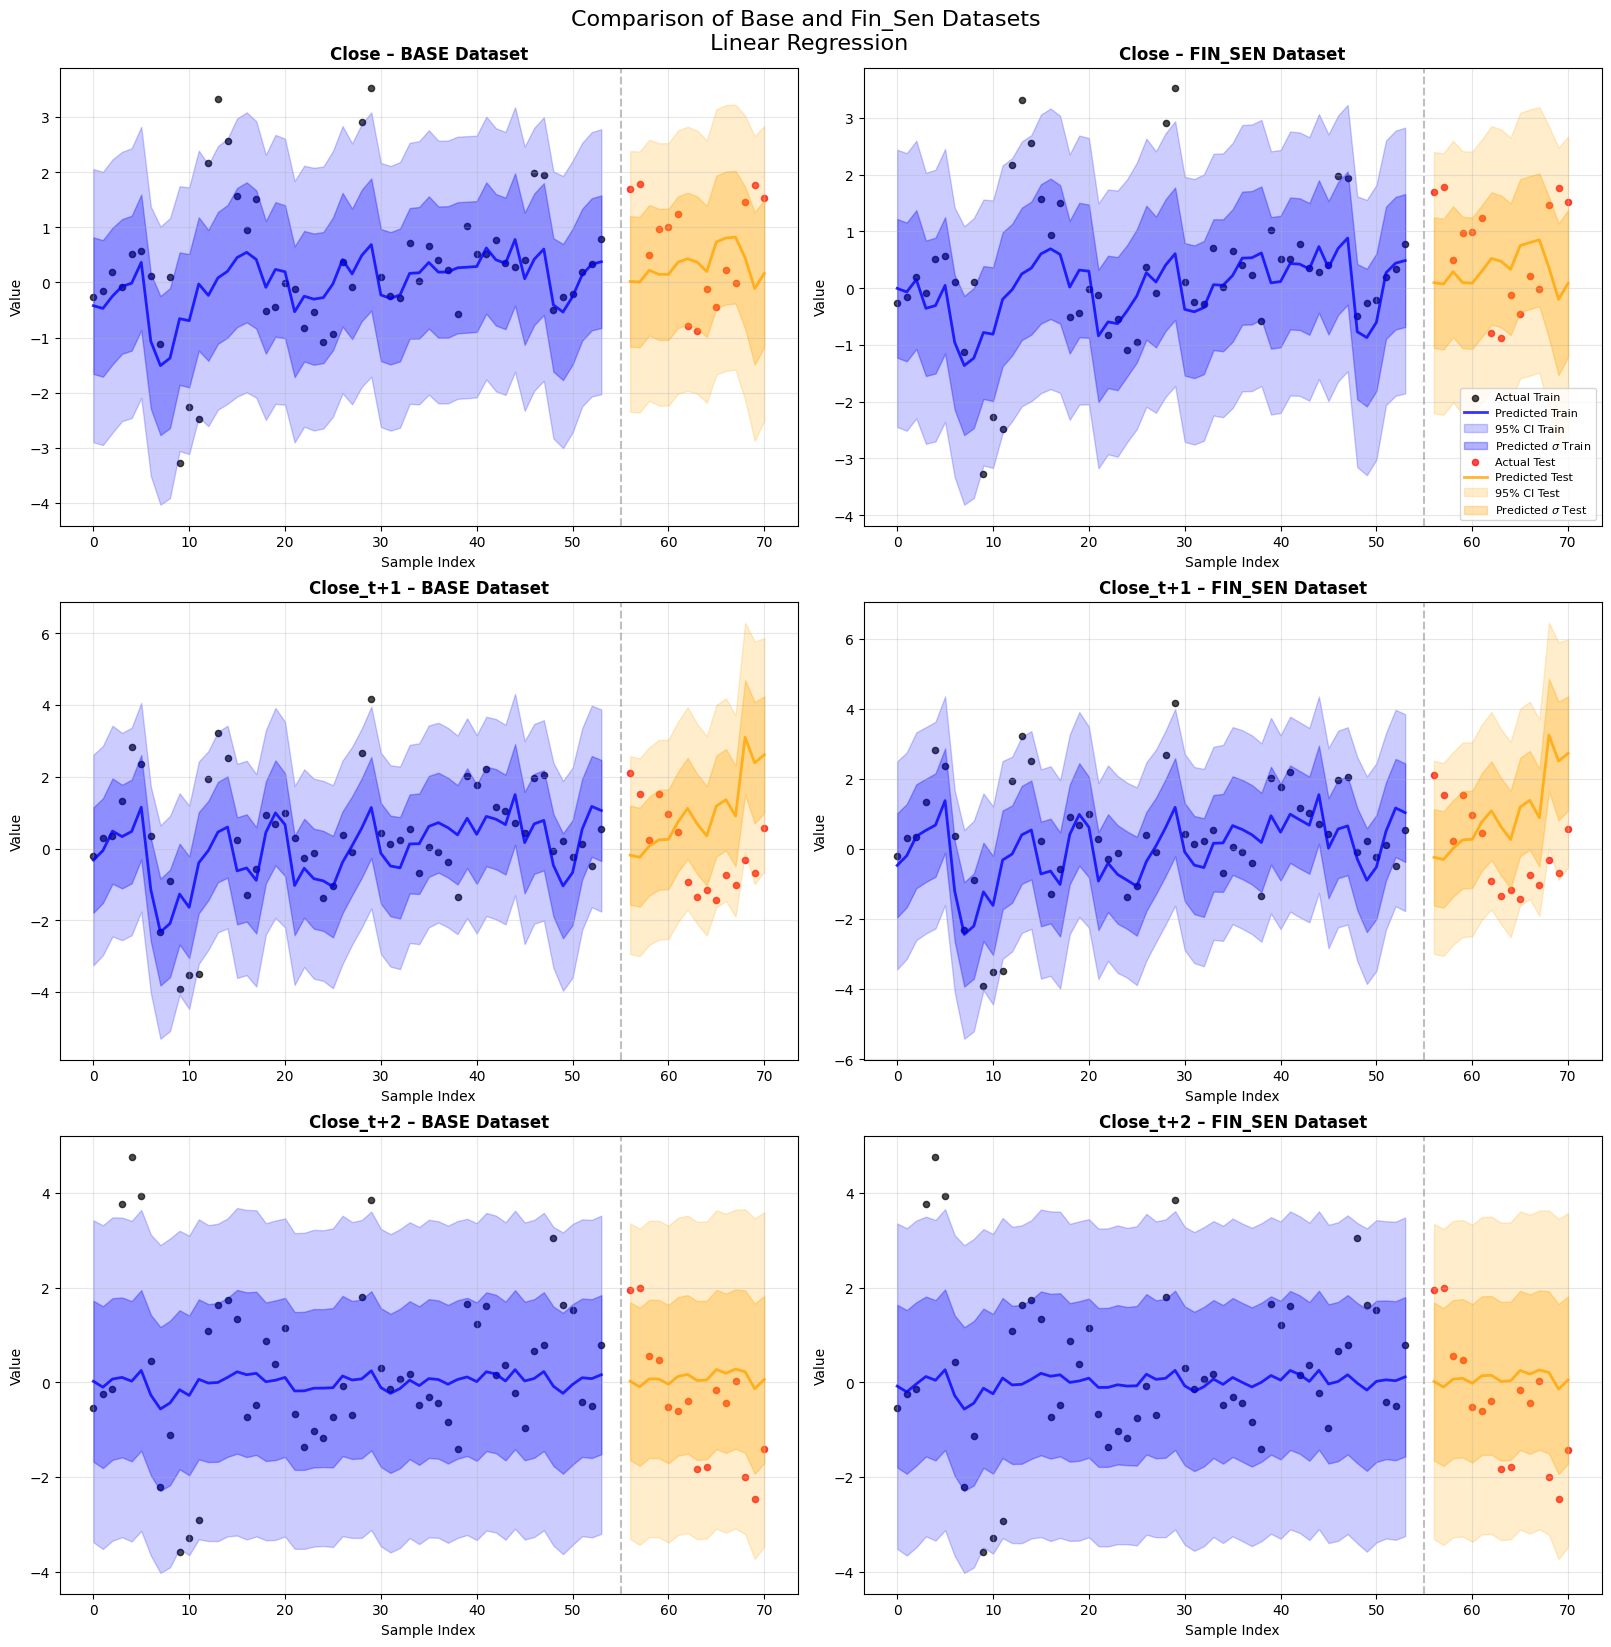

📁 Download files:


/kaggle/working/bayesian_ridge_comparison_linear_white.png

/kaggle/working/bayesian_ridge_comparison_linear_transparent.png

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import os

# Create directory if it doesn't exist
os.makedirs('/kaggle/working', exist_ok=True)

# Define target columns
target_columns = ['Close', 'Close_t+1', 'Close_t+2']

# Define 2 different datasets (train/test pairs) - only base and fin_sen
datasets = {
    'base': {'train': train_set, 'test': test_set},
    'fin_sen': {'train': train_fin_sen, 'test': test_fin_sen}
}

# Define target-specific Bayesian Ridge parameters
target_params = {
    'Close': {
        'n_iter': 1,
        'tol': 1e-07,
        'alpha_1': 1e-06,
        'alpha_2': 1e-05,
        'lambda_1': 1e-05,
        'lambda_2': 1e-06,
        'alpha_init': 0.1,
        'lambda_init': None,
        'fit_intercept': False
    },
    'Close_t+1': {
        'n_iter': 1,
        'tol': 1e-07,
        'alpha_1': 1e-05,
        'alpha_2': 1e-06,
        'lambda_1': 1e-06,
        'lambda_2': 1e-05,
        'alpha_init': 1.0,
        'lambda_init': 0.01,
        'fit_intercept': False
    },
    'Close_t+2': {
        'n_iter': 1,
        'tol': 1e-07,
        'alpha_1': 1e-06,
        'alpha_2': 1e-05,
        'lambda_1': 1e-05,
        'lambda_2': 1e-06,
        'alpha_init': 0.01,
        'lambda_init': None,
        'fit_intercept': False
    }
}

# Plotting setup: 3 rows (targets) x 2 columns (datasets)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 16), constrained_layout=True)

for i, target in enumerate(target_columns):
    for j, dataset_name in enumerate(datasets.keys()):
        data = datasets[dataset_name]
        train_data = data['train']
        test_data = data['test']
        
        # Get feature columns (exclude target columns)
        feature_columns = [c for c in train_data.columns if c not in target_columns]
        
        # Prepare and scale features
        X_train = train_data[feature_columns].values
        X_test = test_data[feature_columns].values
        scaler = StandardScaler().fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Prepare targets
        y_train = train_data[target].values
        y_test = test_data[target].values
        
        # Get target-specific parameters
        params = target_params[target]
        
        # Create and train Bayesian Ridge model with target-specific parameters
        model = BayesianRidge(**params)
        model.fit(X_train_scaled, y_train)
        
        # Make predictions with uncertainty
        pred_train, train_std = model.predict(X_train_scaled, return_std=True)
        pred_test, test_std = model.predict(X_test_scaled, return_std=True)
        
        # Calculate metrics
        metrics = {
            'train_r2': r2_score(y_train, pred_train),
            'test_r2': r2_score(y_test, pred_test),
            'train_mse': mean_squared_error(y_train, pred_train),
            'test_mse': mean_squared_error(y_test, pred_test)
        }
        
        # Plot
        ax = axes[i, j]
        N_train = len(y_train)
        N_test = len(y_test)
        
        # Plot training data
        ax.scatter(np.arange(N_train), y_train, label='Actual Train', s=20, color='black', alpha=0.7)
        ax.plot(np.arange(N_train), pred_train, 
               label='Predicted Train', 
               color='blue', linewidth=2, alpha=0.8)
        ax.fill_between(np.arange(N_train), pred_train - 2*train_std, pred_train + 2*train_std, 
                       alpha=0.2, color='blue', label='95% CI Train')
        ax.fill_between(np.arange(N_train), pred_train - train_std, pred_train + train_std, 
                       alpha=0.3, color='blue', label=r'Predicted $\sigma$ Train')
        
        # Add test data overlay
        test_offset = N_train + 2  # Small gap between train and test
        ax.scatter(np.arange(test_offset, test_offset + N_test), y_test, 
                  label='Actual Test', s=20, color='red', alpha=0.7)
        ax.plot(np.arange(test_offset, test_offset + N_test), pred_test, 
               label='Predicted Test', 
               color='orange', linewidth=2, alpha=0.8)
        ax.fill_between(np.arange(test_offset, test_offset + N_test), 
                       pred_test - 2*test_std, pred_test + 2*test_std, 
                       alpha=0.2, color='orange', label='95% CI Test')
        ax.fill_between(np.arange(test_offset, test_offset + N_test), 
                       pred_test - test_std, pred_test + test_std, 
                       alpha=0.3, color='orange', label=r'Predicted $\sigma$ Test')
        
        # Add vertical line to separate train/test
        ax.axvline(x=N_train + 1, color='gray', linestyle='--', alpha=0.5)
        
        ax.set_title(f'{target} – {dataset_name.upper()} Dataset', fontsize=12, fontweight='bold')
        ax.set_xlabel('Sample Index')
        ax.set_ylabel('Value')
        ax.grid(alpha=0.3)
        
        # Add legend only to the first row, right column (top-right plot)
        if i == 0 and j == 1:
            ax.legend(fontsize=8, loc='lower right')

plt.suptitle('Comparison of Base and Fin_Sen Datasets\n Linear Regression', 
             fontsize=16, y=1.02)

# Save with white background
plt.savefig('/kaggle/working/bayesian_ridge_comparison_linear_white.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')

# Save with transparent background
plt.savefig('/kaggle/working/bayesian_ridge_comparison_linear_transparent.png', dpi=300, bbox_inches='tight', 
            transparent=True, edgecolor='none')

plt.show()

# Provide download links for Kaggle
from IPython.display import FileLink, display
print("📁 Download files:")
display(FileLink('/kaggle/working/bayesian_ridge_comparison_linear_white.png'))
display(FileLink('/kaggle/working/bayesian_ridge_comparison_linear_transparent.png'))


In [118]:
#Als Vergleich nur mit normaler Linear Regression!!!
import numpy as np
import pandas as pd
from joblib import dump
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Define target columns
target_columns = ['Close', 'Close_t+1', 'Close_t+2']

# Define 2 different datasets (train/test pairs) - only base and fin_sen
datasets = {
    'base': {'train': train_set, 'test': test_set},
    'fin_sen': {'train': train_fin_sen, 'test': test_fin_sen}
}

# Define target-specific Linear Regression parameters
target_params = {
    'Close': {
        'fit_intercept': False
    },
    'Close_t+1': {
        'fit_intercept': False
    },
    'Close_t+2': {
        'fit_intercept': False
    }
}

# Initialize results list
results = []

# Main loop: Iterate through datasets
for dataset_name, data in datasets.items():
    
    train_data = data['train']
    test_data = data['test']
    
    # Get feature columns (exclude target columns)
    feature_columns = [col for col in train_data.columns if col not in target_columns]
    
    # Prepare data arrays for current dataset
    X_train = train_data[feature_columns].values
    X_test = test_data[feature_columns].values
    
    # Create separate scaler for each dataset
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Create target dictionaries for current dataset
    y_train_dict = {t: train_data[t].values for t in target_columns}
    y_test_dict = {t: test_data[t].values for t in target_columns}
    
    # Calculate baseline statistics for current dataset
    baseline_stats = {}
    for t in target_columns:
        y_tr, y_te = y_train_dict[t], y_test_dict[t]
        y_mean = np.mean(y_tr)
        
        baseline_stats[t] = {
            'train_mse': mean_squared_error(y_tr, np.full_like(y_tr, y_mean)),
            'test_mse': mean_squared_error(y_te, np.full_like(y_te, y_mean)),
            'train_r2': r2_score(y_tr, np.full_like(y_tr, y_mean)),
            'test_r2': r2_score(y_te, np.full_like(y_te, y_mean))
        }
    
    # Loop through targets
    for target in target_columns:
        
        y_tr, y_te = y_train_dict[target], y_test_dict[target]
        bl = baseline_stats[target]
        
        # Get target-specific parameters
        linear_params = target_params[target]
        
        # Create Linear Regression model with target-specific parameters
        model = LinearRegression(**linear_params)
        
        # Fit model using scaled features
        model.fit(X_train_scaled, y_tr)
        
        # Calculate train/test predictions and metrics
        train_pred = model.predict(X_train_scaled)
        test_pred = model.predict(X_test_scaled)
        
        train_mse = mean_squared_error(y_tr, train_pred)
        test_mse = mean_squared_error(y_te, test_pred)
        train_r2 = r2_score(y_tr, train_pred)
        test_r2 = r2_score(y_te, test_pred)
        
        # Format metrics with baseline
        train_mse_str = f"{train_mse:.4f} ({bl['train_mse']:.4f})"
        test_mse_str = f"{test_mse:.4f} ({bl['test_mse']:.4f})"
        train_r2_str = f"{train_r2:.4f} ({bl['train_r2']:.4f})"
        test_r2_str = f"{test_r2:.4f} ({bl['test_r2']:.4f})"
        
        # Store results WITHOUT CV_MSE
        results.append({
            'Target': target,
            'Model': dataset_name,
            'Train_MSE': train_mse_str,
            'Test_MSE': test_mse_str,
            'Train_R²': train_r2_str,
            'Test_R²': test_r2_str,
            'Best_Params': linear_params
        })
        
        # Save the model
        dump(model, f"linear_model_{dataset_name}_{target}.joblib")

# Create DataFrame WITHOUT CV_MSE
df_results = pd.DataFrame(results)

# Funktion zum Extrahieren des numerischen Train_MSE-Werts aus dem formatierten String
def extract_train_mse(value):
    return float(value.split(' (')[0])

# Sortieren nach Target und dann nach kleinstem Train_MSE innerhalb jeder Target-Kategorie
df_results['Train_MSE_num'] = df_results['Train_MSE'].apply(extract_train_mse)
df_results_sorted = df_results.sort_values(by=['Target', 'Train_MSE_num']).reset_index(drop=True)

# Ausgabe vorbereiten mit Leerzeilen zwischen Target-Kategorien
output_lines = []
current_target = None
for idx, row in df_results_sorted.iterrows():
    if current_target != row['Target']:
        if current_target is not None:
            output_lines.append('')  # Leerzeile vor neuer Target-Kategorie
        current_target = row['Target']
    line = f"{row['Target']:<10} {row['Model']:<10} {row['Train_MSE']:<20} {row['Test_MSE']:<20} {row['Train_R²']:<15} {row['Test_R²']:<15}"
    output_lines.append(line)

# Header und Trenner
header = f"{'Target':<10} {'Model':<10} {'Train_MSE':<20} {'Test_MSE':<20} {'Train_R²':<15} {'Test_R²':<15}"
separator = '-' * len(header)

# Display results with sorted output and blank lines between targets
print("\n" + "="*80)
print("RESULTS SUMMARY - LINEAR REGRESSION:")
print("="*80)

# Endausgabe
final_output = '\n'.join([header, separator] + output_lines)
print(final_output)



RESULTS SUMMARY - LINEAR REGRESSION:
Target     Model      Train_MSE            Test_MSE             Train_R²        Test_R²        
-----------------------------------------------------------------------------------------------
Close      fin_sen    1.1237 (1.5769)      1.3422 (0.9743)      0.2874 (0.0000) -0.6126 (-0.1706)
Close      base       1.1858 (1.5769)      1.2747 (0.9743)      0.2481 (0.0000) -0.5314 (-0.1706)

Close_t+1  fin_sen    1.5300 (2.4972)      5.6279 (1.3888)      0.3873 (0.0000) -3.4816 (-0.1059)
Close_t+1  base       1.5735 (2.4972)      5.3187 (1.3888)      0.3699 (0.0000) -3.2354 (-0.1059)

Close_t+2  fin_sen    1.5469 (2.7915)      7.1470 (2.1635)      0.4458 (0.0000) -3.2827 (-0.2964)
Close_t+2  base       2.0166 (2.7915)      5.7361 (2.1635)      0.2776 (0.0000) -2.4373 (-0.2964)


# Hyperparamter Suche Polynomial

In [142]:
#Search Hyperparamters Polynomial Order and Bayesian Ridge Regression Parameters
import numpy as np
import pandas as pd
from joblib import dump
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline

# Define target and feature columns
target_columns = ['Close', 'Close_t+1', 'Close_t+2']
feature_columns = [col for col in train_set.columns if col not in target_columns]

# Prepare data arrays
X_train = train_set[feature_columns].values
X_test = test_set[feature_columns].values

# Create target dictionaries
y_train_dict = {t: train_set[t].values for t in target_columns}
y_test_dict = {t: test_set[t].values for t in target_columns}

# Calculate baseline statistics
baseline_stats = {}
for t in target_columns:
    y_tr, y_te = y_train_dict[t], y_test_dict[t]
    y_mean = np.mean(y_tr)
    
    baseline_stats[t] = {
        'train_mse': mean_squared_error(y_tr, np.full_like(y_tr, y_mean)),
        'test_mse': mean_squared_error(y_te, np.full_like(y_te, y_mean)),
        'train_r2': r2_score(y_tr, np.full_like(y_tr, y_mean)),
        'test_r2': r2_score(y_te, np.full_like(y_te, y_mean))
    }

# Scale features
scaler = StandardScaler()

# Define parameter grids for models - ONLY POLYNOMIAL MODELS
param_grids = {
    'PolynomialLinear': {
        'model': Pipeline([
            ('polynomial', PolynomialFeatures()),
            ('regressor', LinearRegression())
        ]),
        'params': {
            'polynomial__degree': [2, 3],
            'regressor__fit_intercept': [True, False]
        }
    },
    'PolynomialBayesian': {
        'model': Pipeline([
            ('polynomial', PolynomialFeatures()),
            ('regressor', BayesianRidge())
        ]),
         'params': {
            'polynomial__degree': [2, 3],
            'regressor__n_iter': [1, 2, 3],
            'regressor__tol': np.logspace(-7, -6, 2),
            'regressor__alpha_1': np.logspace(-6, -5, 2),
            'regressor__alpha_2': np.logspace(-6, -5, 2),
            'regressor__lambda_1': np.logspace(-6, -5, 2),
            'regressor__lambda_2': np.logspace(-6, -5, 2),
            'regressor__alpha_init': [1.0, 0.1, 0.01],
            'regressor__lambda_init': [None, 0.1, 0.01],
            'regressor__fit_intercept': [False]
        }
    }
}

# Define single-metric scoring
scoring = 'neg_mean_squared_error'

# Initialize results list
results = []

# Main grid search loop
for target in target_columns:
    y_tr, y_te = y_train_dict[target], y_test_dict[target]
    bl = baseline_stats[target]
    
    for name, cfg in param_grids.items():
        # Configure and run grid search
        grid = GridSearchCV(
            estimator=cfg['model'],
            param_grid=cfg['params'],
            scoring=scoring,
            cv=KFold(n_splits=9, shuffle=False),
            verbose=1,
            n_jobs=-1,
            return_train_score=True
        )
        
        # Perform hyperparameter optimization using scaled features
        grid.fit(scaler.fit_transform(X_train), y_tr)
        
        # Extract best results
        cv_results = grid.cv_results_
        best_params = grid.best_params_
        cv_score   = -grid.best_score_
        
        
        # Use the best model from grid search
        best_model = grid.best_estimator_
        
        # Calculate train/test metrics
        train_pred = best_model.predict(scaler.fit_transform(X_train))
        test_pred = best_model.predict(scaler.transform(X_test))
        
        train_mse = mean_squared_error(y_tr, train_pred)
        test_mse = mean_squared_error(y_te, test_pred)
        train_r2 = r2_score(y_tr, train_pred)
        test_r2 = r2_score(y_te, test_pred)
        
        # Format metrics with baseline
        train_mse_str = f"{train_mse:.4f} ({bl['train_mse']:.4f})"
        test_mse_str = f"{test_mse:.4f} ({bl['test_mse']:.4f})"
        train_r2_str = f"{train_r2:.4f} ({bl['train_r2']:.4f})"
        test_r2_str = f"{test_r2:.4f} ({bl['test_r2']:.4f})"
        
        # Store results
        results.append({
            'Target': target,
            'Model': name,
            'CV_MSE': cv_score,
            'Train_MSE': train_mse_str,
            'Test_MSE': test_mse_str,
            'Train_R²': train_r2_str,
            'Test_R²': test_r2_str,
            'Best_Params': best_params
        })
        
        # Save the best model
        dump(best_model, f"polynomial_model_{target}_{name}.joblib")

# Create DataFrame
df_results = pd.DataFrame(results)


Fitting 9 folds for each of 4 candidates, totalling 36 fits
Fitting 9 folds for each of 1728 candidates, totalling 15552 fits
Fitting 9 folds for each of 4 candidates, totalling 36 fits
Fitting 9 folds for each of 1728 candidates, totalling 15552 fits
Fitting 9 folds for each of 4 candidates, totalling 36 fits
Fitting 9 folds for each of 1728 candidates, totalling 15552 fits


In [128]:
#Only Output of CV Gridsearch
import pandas as pd

# CONFIG - Set your desired filename and title here
EXCEL_FILENAME = "grid_search_results_polynomial_models_MSE.xlsx"
TABLE_TITLE = "POLYNOMIAL GRID SEARCH - BEST RUN PER TARGET (BEST ROW IN BOLD)"

# Define target order
target_columns = ['Close', 'Close_t+1', 'Close_t+2']
df_results['Target'] = pd.Categorical(df_results['Target'], categories=target_columns, ordered=True)

# Sort by Target, then by best CV_MSE
df_sorted = df_results.sort_values(['Target', 'CV_MSE']).reset_index(drop=True)

# Round numerical columns to 3 decimal places
numerical_cols = ['CV_MSE']
for col in numerical_cols:
    df_sorted[col] = df_sorted[col].round(3)

# Function to extract and round values from formatted strings
def extract_and_round_values(formatted_str):
    """Extract main value and baseline from formatted string like '1.4036 (1.5769)'"""
    parts = formatted_str.split(' (')
    main_val = round(float(parts[0]), 3)
    baseline_val = round(float(parts[1].rstrip(')')), 3)
    return f"{main_val:.3f} ({baseline_val:.3f})"

# Function to shorten parameter names
def shorten_param_names(param_dict):
    """Remove 'regressor__' prefix from parameter names"""
    if isinstance(param_dict, dict):
        shortened = {}
        for key, value in param_dict.items():
            new_key = key.replace('regressor__', '')
            shortened[new_key] = value
        return shortened
    return param_dict

# Apply rounding to formatted metric columns
metric_cols = ['Train_MSE', 'Test_MSE', 'Train_R²', 'Test_R²']
for col in metric_cols:
    if col in df_sorted.columns:
        df_sorted[col] = df_sorted[col].apply(extract_and_round_values)

# Shorten parameter names
df_sorted['Best_Params'] = df_sorted['Best_Params'].apply(shorten_param_names)

# Define column headers for display (ohne Best_Params)
headers = ['Target', 'Model', 'CV_MSE', 'Train_MSE', 'Test_MSE', 'Train_R²', 'Test_R²']

# Grouped and formatted output with empty line between targets
print(f"\n{TABLE_TITLE}")
print("="*120)

# Print headers
header_str = ""
col_widths = [12, 20, 10, 18, 18, 15, 15]  # Ohne Best_Params
for i, header in enumerate(headers):
    if header in df_sorted.columns:
        header_str += f"{header:<{col_widths[i]}}"
print(header_str)
print("-" * 120)

# Ausgabe vorbereiten mit Parametern in eigener Zeile
output_lines = []
current_target = None
for idx, row in df_sorted.iterrows():
    if current_target != row['Target']:
        if current_target is not None:
            output_lines.append('')  # Leerzeile vor neuer Target-Kategorie
        current_target = row['Target']
    
    # Erste Zeile mit den Hauptdaten
    row_str = ""
    for j, col in enumerate(headers):
        if col in df_sorted.columns:
            val = str(row[col])
            # Bold für beste Zeile
            idx_best = df_sorted[df_sorted['Target'] == row['Target']]['CV_MSE'].idxmin()
            if idx == idx_best:
                row_str += f"\033[1m{val:<{col_widths[j]}}\033[0m"  # Bold
            else:
                row_str += f"{val:<{col_widths[j]}}"
    output_lines.append(row_str)
    
    # Zweite Zeile mit verkürzten Parametern
    param_line = f"{row['Target']} Parameter: {row['Best_Params']}"
    output_lines.append(param_line)

# Ausgabe
print('\n'.join(output_lines))

# Prepare DataFrame for Excel export (only selected columns that exist)
existing_headers = [h for h in headers if h in df_sorted.columns] + ['Best_Params']
df_export = df_sorted[existing_headers].copy()

# Save DataFrame to Excel file with title
print(f"\nSaving results to {EXCEL_FILENAME}...")
try:
    with pd.ExcelWriter(EXCEL_FILENAME, engine='openpyxl') as writer:
        # Write title in first row
        title_df = pd.DataFrame([[TABLE_TITLE]], columns=[''])
        title_df.to_excel(writer, sheet_name='Results', index=False, header=False, startrow=0)
        
        # Write main data starting from row 2
        df_export.to_excel(writer, sheet_name='Results', index=False, startrow=2)
    
    print(f"✓ File saved successfully!")
    print(f"📁 Excel file location: {EXCEL_FILENAME}")
    
except Exception as e:
    print(f"❌ Error saving Excel file: {e}")
    print("Continuing without Excel export...")



POLYNOMIAL GRID SEARCH - BEST RUN PER TARGET (BEST ROW IN BOLD)
Target      Model               CV_MSE    Train_MSE         Test_MSE          Train_R²       Test_R²        
------------------------------------------------------------------------------------------------------------------------
Close       PolynomialBayesian  2.109     1.319 (1.577)     0.886 (0.974)     0.164 (0.000)  -0.065 (-0.171)
Close Parameter: {'polynomial__degree': 2, 'alpha_1': 1e-06, 'alpha_2': 1e-05, 'alpha_init': 0.01, 'fit_intercept': False, 'lambda_1': 1e-05, 'lambda_2': 1e-06, 'lambda_init': None, 'n_iter': 1, 'tol': 1e-07}
Close       PolynomialLinear    20.805    0.347 (1.577)     19.583 (0.974)    0.780 (0.000)  -22.527 (-0.171)
Close Parameter: {'polynomial__degree': 2, 'fit_intercept': False}

Close_t+1   PolynomialBayesian  3.59      1.847 (2.497)     2.195 (1.389)     0.260 (0.000)  -0.748 (-0.106)
Close_t+1 Parameter: {'polynomial__degree': 2, 'alpha_1': 1e-06, 'alpha_2': 1e-05, 'alpha_init': 0.0

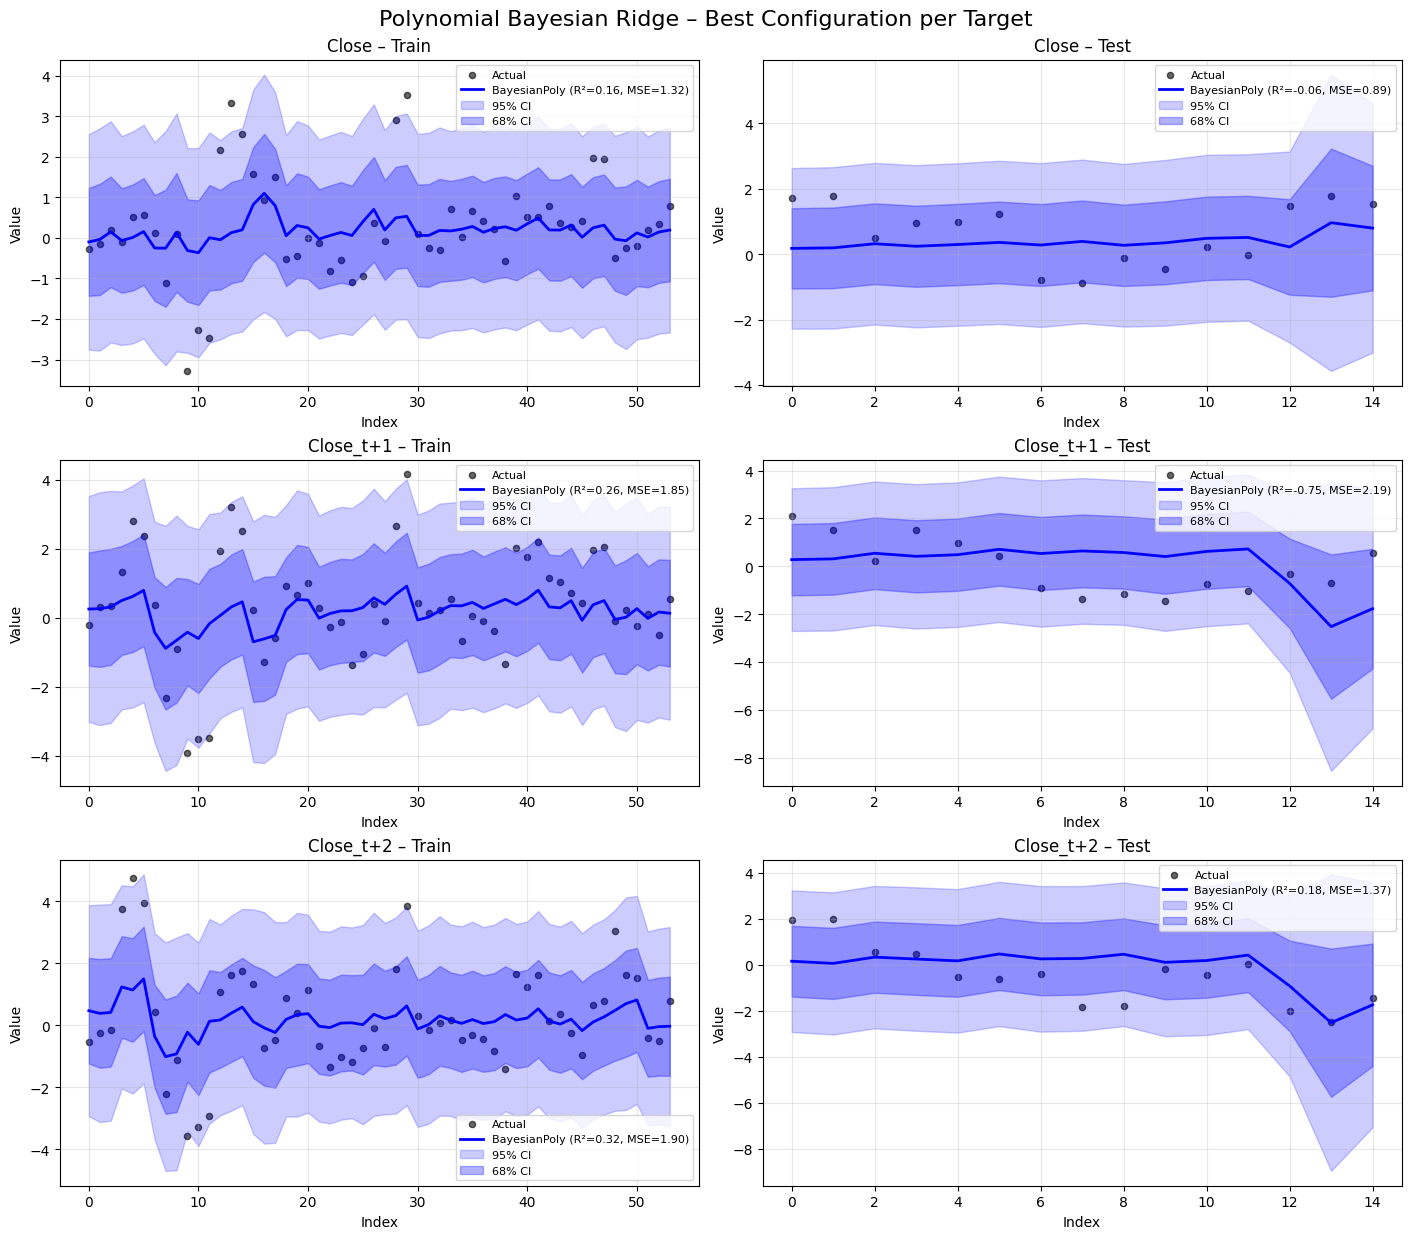

In [129]:
#Neu
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
import pandas as pd

# 1. Define targets & features and scale once
target_columns = ['Close', 'Close_t+1', 'Close_t+2']
feature_columns = [c for c in train_set.columns if c not in target_columns]

X_train = train_set[feature_columns].values
X_test  = test_set[feature_columns].values
scaler  = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s  = scaler.transform(X_test)

# 2. Extract best Bayesian parameters from df_results
best_configs = {}
for t in target_columns:
    grp = df_results[df_results['Target'] == t]
    best = grp.loc[grp['CV_MSE'].idxmin()]
    # Only PolynomialBayesian remains
    best_configs[t] = best['Best_Params']

# 3. Plotting
fig, axes = plt.subplots(3, 2, figsize=(14,12), constrained_layout=True)

for i, target in enumerate(target_columns):
    y_tr = train_set[target].values
    y_te = test_set [target].values

    params = best_configs[target]
    degree = params.pop('polynomial__degree')
    # remove 'regressor__' prefix
    bayes_kwargs = {k.replace('regressor__',''): v for k, v in params.items()}

    # build pipeline
    model = Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('bayes', BayesianRidge(**bayes_kwargs))
    ])
    model.fit(X_train_s, y_tr)

    # predictions with uncertainty
    pred_tr, std_tr = model.predict(X_train_s, return_std=True)
    pred_te, std_te = model.predict(X_test_s, return_std=True)

    metrics = {
        'train_r2':  r2_score(y_tr, pred_tr),
        'test_r2':   r2_score(y_te, pred_te),
        'train_mse':mean_squared_error(y_tr, pred_tr),
        'test_mse': mean_squared_error(y_te, pred_te)
    }

    for j, (kind, y_true, y_pred, std) in enumerate([
        ('Train', y_tr, pred_tr, std_tr),
        ('Test',  y_te, pred_te, std_te)
    ]):
        ax = axes[i, j]
        N = len(y_true)
        ax.scatter(np.arange(N), y_true, color='black', s=20, alpha=0.6, label='Actual')
        ax.plot(   np.arange(N), y_pred, color='blue', lw=2,
                   label=f'BayesianPoly (R²={metrics[f"{kind.lower()}_r2"]:.2f}, MSE={metrics[f"{kind.lower()}_mse"]:.2f})')
        ax.fill_between(np.arange(N), y_pred-2*std, y_pred+2*std, color='blue', alpha=0.2, label='95% CI')
        ax.fill_between(np.arange(N), y_pred-std,   y_pred+std,   color='blue', alpha=0.3, label='68% CI')
        ax.set_title(f"{target} – {kind}")
        ax.set_xlabel("Index")
        ax.set_ylabel("Value")
        ax.legend(fontsize=8)
        ax.grid(alpha=0.3)

plt.suptitle("Polynomial Bayesian Ridge – Best Configuration per Target", fontsize=16, y=1.02)
plt.show()


In [140]:
import numpy as np
import pandas as pd
from joblib import dump
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

# Define target columns
target_columns = ['Close', 'Close_t+1', 'Close_t+2']

# Define 2 datasets: base and fin_sen
datasets = {
    'base':    {'train': train_set,     'test': test_set},
    'fin_sen': {'train': train_fin_sen, 'test': test_fin_sen}
}

# Fixed Bayesian Ridge parameters
bayesian_params = {
    'n_iter':      1,
    'tol':         1e-07,
    'alpha_1':     1e-06,
    'alpha_2':     1e-05,
    'lambda_1':    1e-05,
    'lambda_2':    1e-06,
    'alpha_init':  0.01,
    'lambda_init': None,
    'fit_intercept': False
}

results = []

for dataset_name, data in datasets.items():
    train_data = data['train']
    test_data  = data['test']
    
    feature_columns = [c for c in train_data.columns if c not in target_columns]
    X_train = train_data[feature_columns].values
    X_test  = test_data [feature_columns].values
    
    # 1) Scale raw features
    scaler    = StandardScaler().fit(X_train)
    X_train_s = scaler.transform(X_train)
    X_test_s  = scaler.transform(X_test)
    
    # 2) Create polynomial transformer (2nd degree)
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_train_p = poly.fit_transform(X_train_s)
    X_test_p  = poly.transform(X_test_s)
    
    # Prepare targets
    y_train = {t: train_data[t].values for t in target_columns}
    y_test  = {t: test_data [t].values for t in target_columns}
    
    # Baseline stats
    baseline_stats = {}
    for t in target_columns:
        y_tr, y_te = y_train[t], y_test[t]
        mu = np.mean(y_tr)
        baseline_stats[t] = {
            'train_mse': mean_squared_error(y_tr, np.full_like(y_tr, mu)),
            'test_mse':  mean_squared_error(y_te, np.full_like(y_te, mu)),
            'train_r2':  r2_score(y_tr, np.full_like(y_tr, mu)),
            'test_r2':   r2_score(y_te, np.full_like(y_te, mu))
        }
    
    # Fit & evaluate each target
    for t in target_columns:
        y_tr, y_te = y_train[t], y_test[t]
        bl = baseline_stats[t]
        
        # 3) Bayesian Ridge on polynomial features
        model = BayesianRidge(**bayesian_params)
        model.fit(X_train_p, y_tr)
        
        train_pred = model.predict(X_train_p)
        test_pred  = model.predict(X_test_p)
        
        tmse = mean_squared_error(y_tr, train_pred)
        tmse_str = f"{tmse:.4f} ({bl['train_mse']:.4f})"
        tmsq2 = mean_squared_error(y_te, test_pred)
        tmsq2_str= f"{tmsq2:.4f} ({bl['test_mse']:.4f})"
        tr2 = r2_score(y_tr, train_pred)
        tr2_str= f"{tr2:.4f} ({bl['train_r2']:.4f})"
        te2 = r2_score(y_te, test_pred)
        te2_str= f"{te2:.4f} ({bl['test_r2']:.4f})"
        
        results.append({
            'Target':   t,
            'Model':    dataset_name,
            'Train_MSE': tmse_str,
            'Test_MSE':  tmsq2_str,
            'Train_R²':  tr2_str,
            'Test_R²':   te2_str
        })
        
        dump(model, f"poly2_bayesian_{dataset_name}_{t}.joblib")

# Build and display results
df_results = pd.DataFrame(results)
df_results['Train_MSE_val'] = df_results['Train_MSE'].map(lambda s: float(s.split(' ')[0]))
df_results = df_results.sort_values(['Target','Train_MSE_val']).reset_index(drop=True)

header = f"{'Target':<10}{'Model':<12}{'Train_MSE':<20}{'Test_MSE':<20}{'Train_R²':<15}{'Test_R²':<15}"
sep = '-'*len(header)
print(header); print(sep)
current=None
for _,row in df_results.iterrows():
    if row['Target']!=current:
        if current: print()
        current=row['Target']
    print(f"{row['Target']:<10}{row['Model']:<12}{row['Train_MSE']:<20}{row['Test_MSE']:<20}{row['Train_R²']:<15}{row['Test_R²']:<15}")


Target    Model       Train_MSE           Test_MSE            Train_R²       Test_R²        
--------------------------------------------------------------------------------------------
Close     fin_sen     1.1922 (1.5769)     0.9859 (0.9743)     0.2440 (0.0000)-0.1844 (-0.1706)
Close     base        1.3233 (1.5769)     0.8915 (0.9743)     0.1608 (0.0000)-0.0710 (-0.1706)

Close_t+1 fin_sen     1.7768 (2.4972)     2.2908 (1.3888)     0.2885 (0.0000)-0.8242 (-0.1059)
Close_t+1 base        1.8628 (2.4972)     2.1623 (1.3888)     0.2540 (0.0000)-0.7219 (-0.1059)

Close_t+2 fin_sen     1.6182 (2.7915)     1.4320 (2.1635)     0.4203 (0.0000)0.1419 (-0.2964)
Close_t+2 base        1.8955 (2.7915)     1.3716 (2.1635)     0.3210 (0.0000)0.1781 (-0.2964)


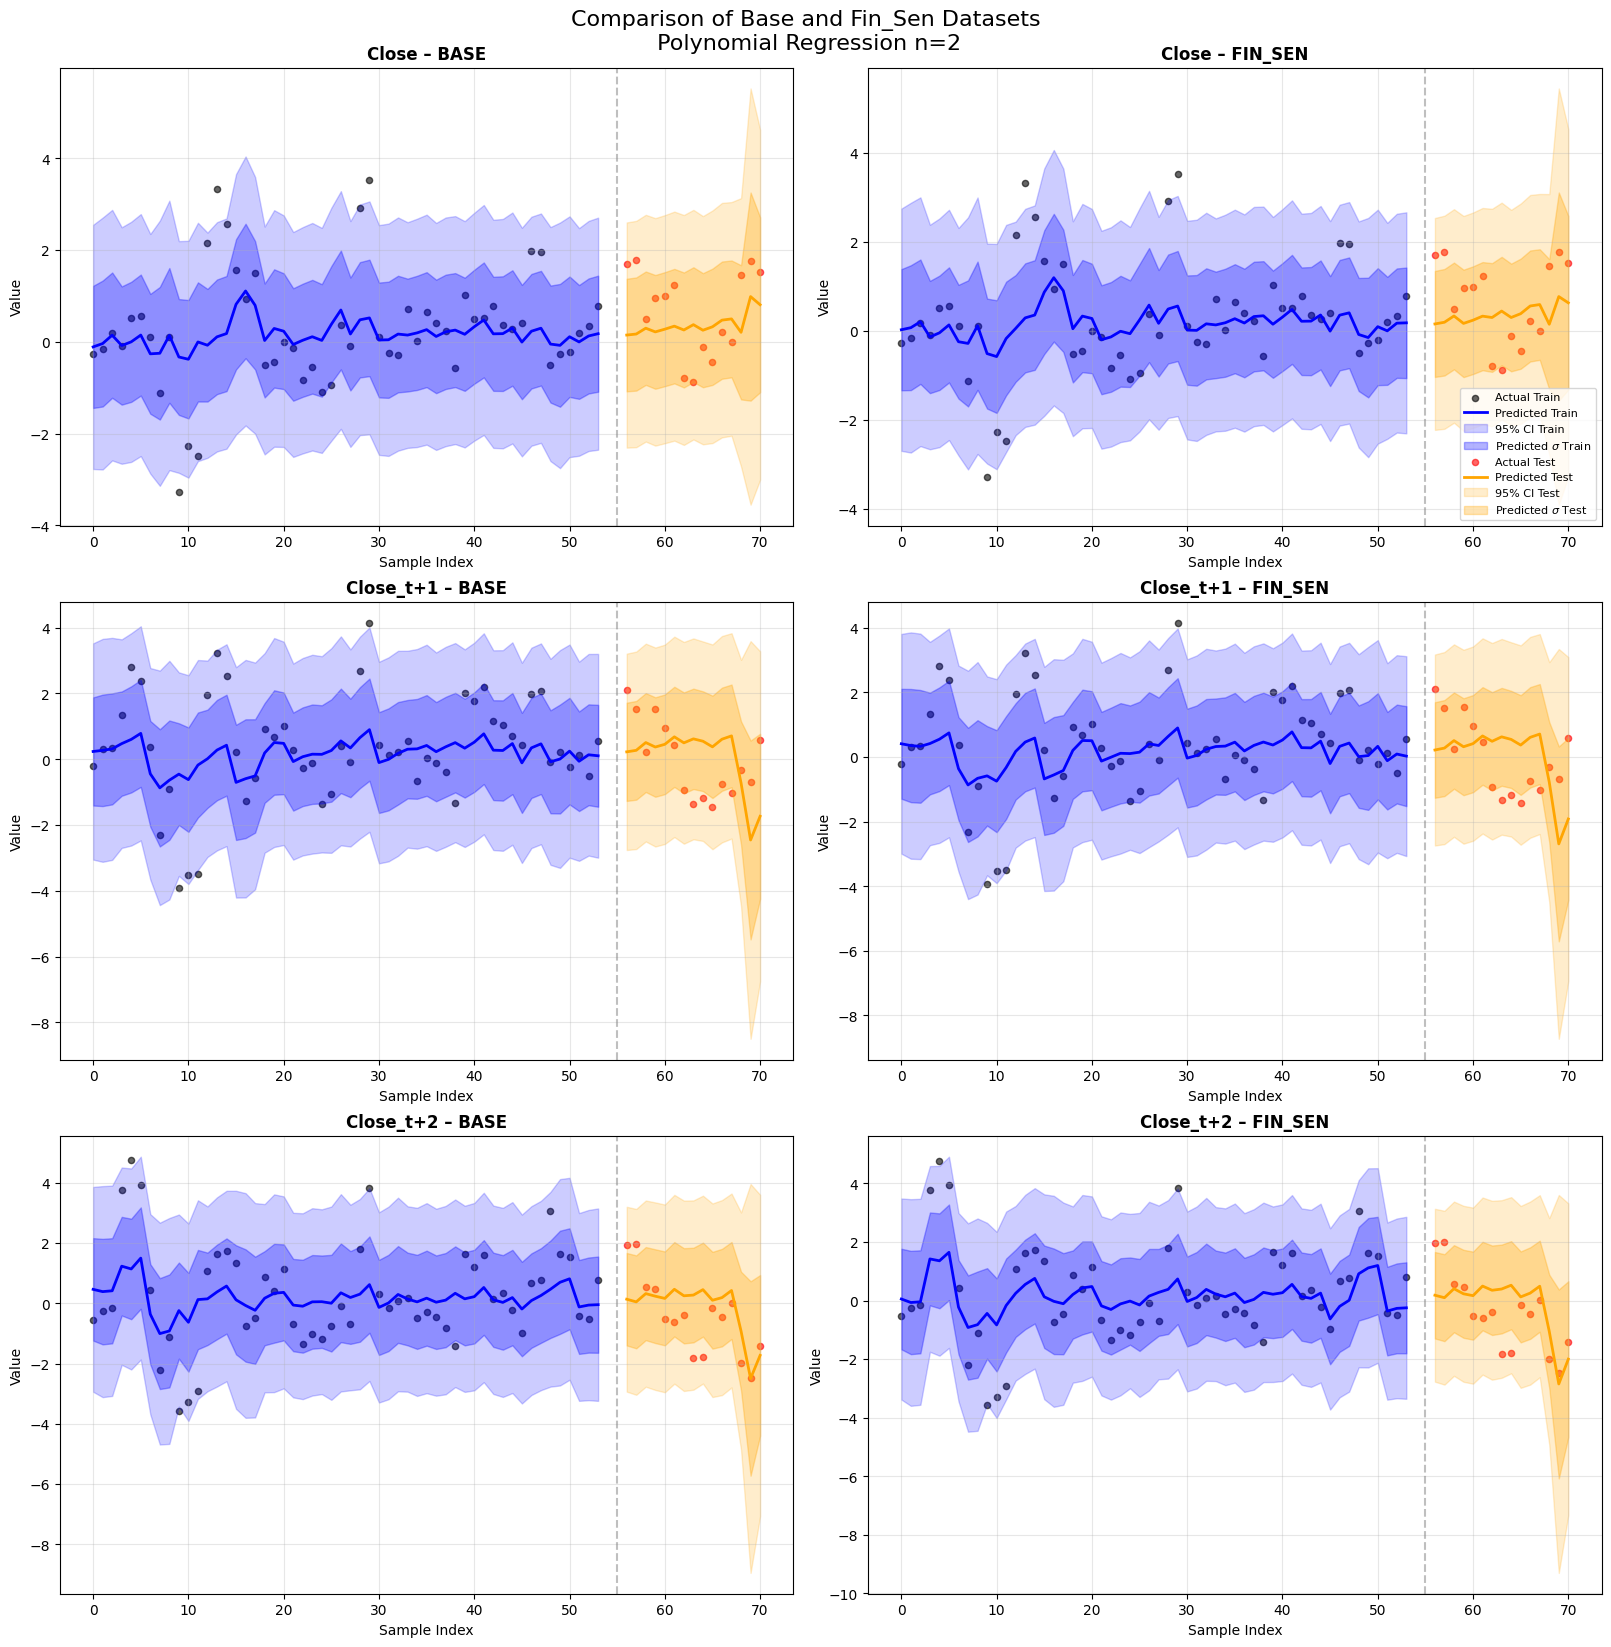

📁 Download files:


/kaggle/working/polynomial_bayesian_ridge_comparison_white.png

/kaggle/working/polynomial_bayesian_ridge_comparison_transparent.png

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import dump
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
import os

# Create directory if it doesn't exist
os.makedirs('/kaggle/working', exist_ok=True)

# 1. Konfiguration
TARGETS = ['Close','Close_t+1','Close_t+2']
DATASETS = {
    'base':    (train_set, test_set),
    'fin_sen': (train_fin_sen, test_fin_sen)
}
PARAMS = {
    'n_iter': 1, 'tol': 1e-7,#1e-7
    'alpha_1': 1e-6, 'alpha_2': 1e-5, #1e-5,
    'lambda_1': 1e-5, 'lambda_2': 1e-6,
    'alpha_init': 0.01, 'lambda_init': None,
    'fit_intercept': False
}

fig, axes = plt.subplots(len(TARGETS), 2, figsize=(16,16), constrained_layout=True)

for i, t in enumerate(TARGETS):
    for j, (name, (df_tr, df_te)) in enumerate(DATASETS.items()):
        # Features & Targets
        X_tr = df_tr.drop(columns=TARGETS).values
        y_tr = df_tr[t].values
        X_te = df_te.drop(columns=TARGETS).values
        y_te = df_te[t].values

        # 2) Fit scaler + polynomial on TRAIN of this dataset
        scaler = StandardScaler().fit(X_tr)
        X_tr_s = scaler.transform(X_tr)
        X_te_s = scaler.transform(X_te)

        poly = PolynomialFeatures(degree=2, include_bias=False).fit(X_tr_s)
        X_tr_p = poly.transform(X_tr_s)
        X_te_p = poly.transform(X_te_s)

        # 3) Train Bayesian Ridge auf polyn. Features
        model = BayesianRidge(**PARAMS)
        model.fit(X_tr_p, y_tr)

        # 4) Vorhersagen + Metriken
        pred_tr, std_tr = model.predict(X_tr_p, return_std=True)
        pred_te, std_te = model.predict(X_te_p, return_std=True)

        m_tr = mean_squared_error(y_tr, pred_tr)
        r2_tr = r2_score(y_tr, pred_tr)
        m_te = mean_squared_error(y_te, pred_te)
        r2_te = r2_score(y_te, pred_te)

        # 5) Plotten
        ax = axes[i, j]
        N1, N2 = len(y_tr), len(y_te)

        ax.scatter(np.arange(N1), y_tr, color='black', s=20, alpha=0.6, label='Actual Train')
        ax.plot(   np.arange(N1), pred_tr, color='blue', lw=2,
                   label='Predicted Train')
        ax.fill_between(np.arange(N1), pred_tr-2*std_tr, pred_tr+2*std_tr, color='blue', alpha=0.2, label='95% CI Train')
        ax.fill_between(np.arange(N1), pred_tr-std_tr, pred_tr+std_tr, color='blue', alpha=0.3, label=r'Predicted $\sigma$ Train')

        offset = N1 + 2
        ax.scatter(np.arange(offset, offset+N2), y_te, color='red', s=20, alpha=0.6, label='Actual Test')
        ax.plot(   np.arange(offset, offset+N2), pred_te, color='orange', lw=2,
                   label='Predicted Test')
        ax.fill_between(np.arange(offset, offset+N2), pred_te-2*std_te, pred_te+2*std_te, color='orange', alpha=0.2, label='95% CI Test')
        ax.fill_between(np.arange(offset, offset+N2), pred_te-std_te, pred_te+std_te, color='orange', alpha=0.3, label=r'Predicted $\sigma$ Test')

        ax.axvline(x=offset-1, color='gray', linestyle='--', alpha=0.5)
        ax.set_title(f'{t} – {name.upper()}', fontweight='bold')
        ax.set_xlabel('Sample Index')
        ax.set_ylabel('Value')
        
        # Add legend only to the first row, right column (top-right plot)
        if i == 0 and j == 1:
            ax.legend(fontsize=8, loc='lower right')
        
        ax.grid(alpha=0.3)

        # Modell speichern
        dump(model, f"poly2_bayes_{name}_{t}.joblib")

plt.suptitle("Comparison of Base and Fin_Sen Datasets\n Polynomial Regression n=2", fontsize=16, y=1.02)

# Save with white background
plt.savefig('/kaggle/working/polynomial_bayesian_ridge_comparison_polynomial_white.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')

# Save with transparent background
plt.savefig('/kaggle/working/polynomial_bayesian_ridge_comparison_polynomial_transparent.png', dpi=300, bbox_inches='tight', 
            transparent=True, edgecolor='none')

plt.show()

# Provide download links for Kaggle
from IPython.display import FileLink, display
print("📁 Download files:")
display(FileLink('/kaggle/working/polynomial_bayesian_ridge_comparison_white.png'))
display(FileLink('/kaggle/working/polynomial_bayesian_ridge_comparison_transparent.png'))


In [158]:
#Neu
import numpy as np
import pandas as pd
from joblib import dump
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline

# Define target and feature columns
target_columns = ['Close', 'Close_t+1', 'Close_t+2']
feature_columns = [col for col in train_set.columns if col not in target_columns]

# Prepare data arrays
X_train = train_set[feature_columns].values
X_test = test_set[feature_columns].values

# Create target dictionaries
y_train_dict = {t: train_set[t].values for t in target_columns}
y_test_dict = {t: test_set[t].values for t in target_columns}

# Calculate baseline statistics
baseline_stats = {}
for t in target_columns:
    y_tr, y_te = y_train_dict[t], y_test_dict[t]
    y_mean = np.mean(y_tr)
    
    baseline_stats[t] = {
        'train_mse': mean_squared_error(y_tr, np.full_like(y_tr, y_mean)),
        'test_mse': mean_squared_error(y_te, np.full_like(y_te, y_mean)),
        'train_r2': r2_score(y_tr, np.full_like(y_tr, y_mean)),
        'test_r2': r2_score(y_te, np.full_like(y_te, y_mean))
    }

# Scale features
scaler = StandardScaler()

# Define parameter grids for models - ONLY POLYNOMIAL MODELS
param_grids = {
    'PolynomialLinear': {
        'model': Pipeline([
            ('polynomial', PolynomialFeatures()),
            ('regressor', LinearRegression())
        ]),
        'params': {
            'polynomial__degree': [2, 3],
            'regressor__fit_intercept': [True, False]
        }
    },
    'PolynomialBayesian': {
        'model': Pipeline([
            ('polynomial', PolynomialFeatures()),
            ('regressor', BayesianRidge())
        ]),
         'params': {
            'polynomial__degree': [4,7,10],
            'regressor__n_iter': [10,100,300],
            'regressor__tol': np.logspace(-7, -3, 4),
            'regressor__alpha_init': [1.0, 0.1, 0.01],
            'regressor__lambda_init': [None, 0.1, 0.01],
            'regressor__fit_intercept': [False]
        }
    }
}

# Define single-metric scoring
scoring = 'neg_mean_squared_error'

# Initialize results list
results = []

# Main grid search loop
for target in target_columns:
    y_tr, y_te = y_train_dict[target], y_test_dict[target]
    bl = baseline_stats[target]
    
    for name, cfg in param_grids.items():
        # Configure and run grid search
        grid = GridSearchCV(
            estimator=cfg['model'],
            param_grid=cfg['params'],
            scoring=scoring,
            cv=KFold(n_splits=9, shuffle=False),
            verbose=1,
            n_jobs=-1,
            return_train_score=True
        )
        
        # Perform hyperparameter optimization using scaled features
        grid.fit(scaler.fit_transform(X_train), y_tr)
        
        # Extract best results
        cv_results = grid.cv_results_
        best_params = grid.best_params_
        cv_score   = -grid.best_score_
        
        
        # Use the best model from grid search
        best_model = grid.best_estimator_
        
        # Calculate train/test metrics
        train_pred = best_model.predict(scaler.fit_transform(X_train))
        test_pred = best_model.predict(scaler.transform(X_test))
        
        train_mse = mean_squared_error(y_tr, train_pred)
        test_mse = mean_squared_error(y_te, test_pred)
        train_r2 = r2_score(y_tr, train_pred)
        test_r2 = r2_score(y_te, test_pred)
        
        # Format metrics with baseline
        train_mse_str = f"{train_mse:.4f} ({bl['train_mse']:.4f})"
        test_mse_str = f"{test_mse:.4f} ({bl['test_mse']:.4f})"
        train_r2_str = f"{train_r2:.4f} ({bl['train_r2']:.4f})"
        test_r2_str = f"{test_r2:.4f} ({bl['test_r2']:.4f})"
        
        # Store results
        results.append({
            'Target': target,
            'Model': name,
            'CV_MSE': cv_score,
            'Train_MSE': train_mse_str,
            'Test_MSE': test_mse_str,
            'Train_R²': train_r2_str,
            'Test_R²': test_r2_str,
            'Best_Params': best_params
        })
        
        # Save the best model
        dump(best_model, f"polynomial_model_{target}_{name}.joblib")

# Create DataFrame
df_results = pd.DataFrame(results)


Fitting 9 folds for each of 4 candidates, totalling 36 fits


KeyboardInterrupt: 

In [167]:
import numpy as np
import pandas as pd
from joblib import dump
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

# 1. Define target and feature columns
target_columns  = ['Close', 'Close_t+1', 'Close_t+2']

# 2. Fixed Bayesian Ridge parameters (excluding polynomial__degree)
bayesian_params = {
    'n_iter':        1,
    'tol':           1e-07,
    'alpha_1':       1e-06,
    'alpha_2':       1e-05,
    'lambda_1':      1e-05,
    'lambda_2':      1e-06,
    'alpha_init':    0.01,
    'lambda_init':   None,
    'fit_intercept': False
}

# 3. Loop through each dataset
for ds_name, df in [('base', train_set), ('finbert', train_fin_sen)]:
    print(f"\n=== Polynomial Feature Weights for Dataset '{ds_name}' (degree=2) ===")
    
    # Dynamically determine feature columns
    feature_columns = [c for c in df.columns if c not in target_columns]
    
    # Build a pipeline: scaling → polynomial degree=2 → BayesianRidge
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('bayes', BayesianRidge(**bayesian_params))
    ])
    
    # Fit and extract coefficients for each target
    for target in target_columns:
        X = df[feature_columns].values
        y = df[target].values
        
        # Train pipeline
        pipeline.fit(X, y)
        
        # Extract polynomial feature names
        poly = pipeline.named_steps['poly']
        feature_names = poly.get_feature_names_out(feature_columns)
        
        # Extract learned coefficients
        coefs = pipeline.named_steps['bayes'].coef_
        
        # Create a Series and sort by absolute value
        coef_series = pd.Series(coefs, index=feature_names)
        sorted_feats = coef_series.abs().sort_values(ascending=False).index
        
        # Print weights
        print(f"\n-- Weights for target '{target}':")
        for feat in sorted_feats:
            print(f"{feat:<30} {coef_series[feat]: .6f}")
        
        # Optionally save the model
        dump(pipeline, f"poly2_bayes_{ds_name}_{target}.joblib")



=== Polynomial Feature Weights for Dataset 'base' (degree=2) ===

-- Weights for target 'Close':
Interest Rate_Change           -0.089457
Close_t-4                       0.087872
Close_t-3                       0.087262
Index_SDAX^2                    0.054570
Interest Rate_Change^2         -0.043173
Close_t-2 Interest Rate_Change -0.037716
Index_MDAX^2                    0.036567
Close_t-2^2                     0.036479
Index_MDAX Index_SDAX          -0.032126
Close_t-2 Interest Rate_Old     0.029122
Interest Rate_Old               0.028814
Close_t-3 Close_t-2             0.023290
Index_SDAX                      0.021537
Close_t-4 Index_MDAX            0.020776
Close_t-3 Index_MDAX            0.019756
Close_t-4^2                     0.018375
Close_t-4 Close_t-2             0.017108
Index_MDAX Interest Rate_Change -0.013440
Close_t-3 Interest Rate_Old     0.013200
Close_t-3^2                     0.009252
Close_t-3 Interest Rate_Change  0.007076
Close_t-4 Close_t-3             0.005310

In [ ]:
#Neu
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
import pandas as pd

# 1. Define targets & features and scale once
target_columns = ['Close', 'Close_t+1', 'Close_t+2']
feature_columns = [c for c in train_set.columns if c not in target_columns]

X_train = train_set[feature_columns].values
X_test  = test_set[feature_columns].values
scaler  = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s  = scaler.transform(X_test)

# 2. Extract best Bayesian parameters from df_results
best_configs = {}
for t in target_columns:
    grp = df_results[df_results['Target'] == t]
    best = grp.loc[grp['CV_MSE'].idxmin()]
    # Only PolynomialBayesian remains
    best_configs[t] = best['Best_Params']

# 3. Plotting
fig, axes = plt.subplots(3, 2, figsize=(14,12), constrained_layout=True)

for i, target in enumerate(target_columns):
    y_tr = train_set[target].values
    y_te = test_set [target].values

    params = best_configs[target]
    degree = params.pop('polynomial__degree')
    # remove 'regressor__' prefix
    bayes_kwargs = {k.replace('regressor__',''): v for k, v in params.items()}

    # build pipeline
    model = Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('bayes', BayesianRidge(**bayes_kwargs))
    ])
    model.fit(X_train_s, y_tr)

    # predictions with uncertainty
    pred_tr, std_tr = model.predict(X_train_s, return_std=True)
    pred_te, std_te = model.predict(X_test_s, return_std=True)

    metrics = {
        'train_r2':  r2_score(y_tr, pred_tr),
        'test_r2':   r2_score(y_te, pred_te),
        'train_mse':mean_squared_error(y_tr, pred_tr),
        'test_mse': mean_squared_error(y_te, pred_te)
    }

    for j, (kind, y_true, y_pred, std) in enumerate([
        ('Train', y_tr, pred_tr, std_tr),
        ('Test',  y_te, pred_te, std_te)
    ]):
        ax = axes[i, j]
        N = len(y_true)
        ax.scatter(np.arange(N), y_true, color='black', s=20, alpha=0.6, label='Actual')
        ax.plot(   np.arange(N), y_pred, color='blue', lw=2,
                   label=f'BayesianPoly (R²={metrics[f"{kind.lower()}_r2"]:.2f}, MSE={metrics[f"{kind.lower()}_mse"]:.2f})')
        ax.fill_between(np.arange(N), y_pred-2*std, y_pred+2*std, color='blue', alpha=0.2, label='95% CI')
        ax.fill_between(np.arange(N), y_pred-std,   y_pred+std,   color='blue', alpha=0.3, label='68% CI')
        ax.set_title(f"{target} – {kind}")
        ax.set_xlabel("Index")
        ax.set_ylabel("Value")
        ax.legend(fontsize=8)
        ax.grid(alpha=0.3)

plt.suptitle("Polynomial Bayesian Ridge – Best Configuration per Target", fontsize=16, y=1.02)
plt.show()
